

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=10,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_image_count =  int(qbz95.utils.get_notebook_name().split('.')[0].split('_')[3])

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(50000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{  
        'mlp':{'dropout':0.0, 'layer_count':1, 'units':128, 'epochs':80},
        'lenet':{'dropout':0.1, 'epochs':80},
        'custom':{'dropout':0.1, 'epochs':80},
        'vgg':{'dropout':0.3, 'epochs':80},
        'resnet':{'epochs':80}          
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-11 05:53:50,222: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json


### 下载数据

开始下载数据。

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [6]:
if params.train_image_count<5000:
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

In [7]:
Counter(train_labels)

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})



### 查看数据

下面看一看实际的数据是啥样的。

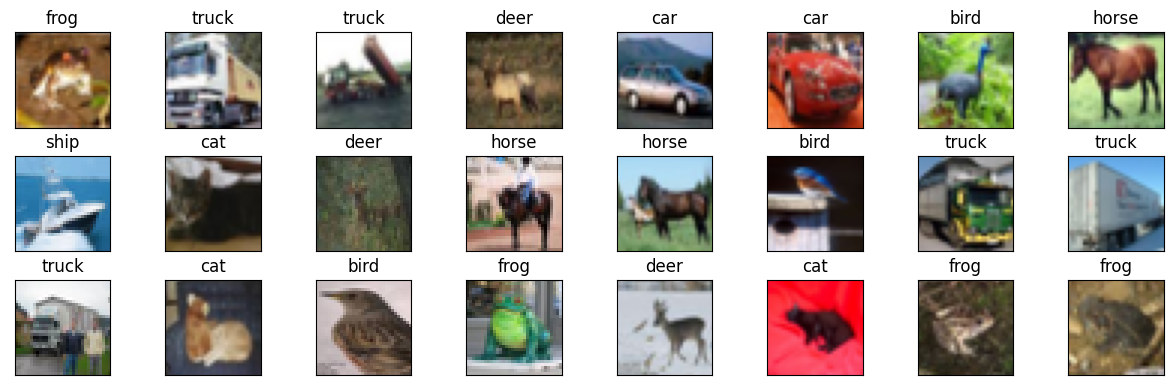

In [8]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

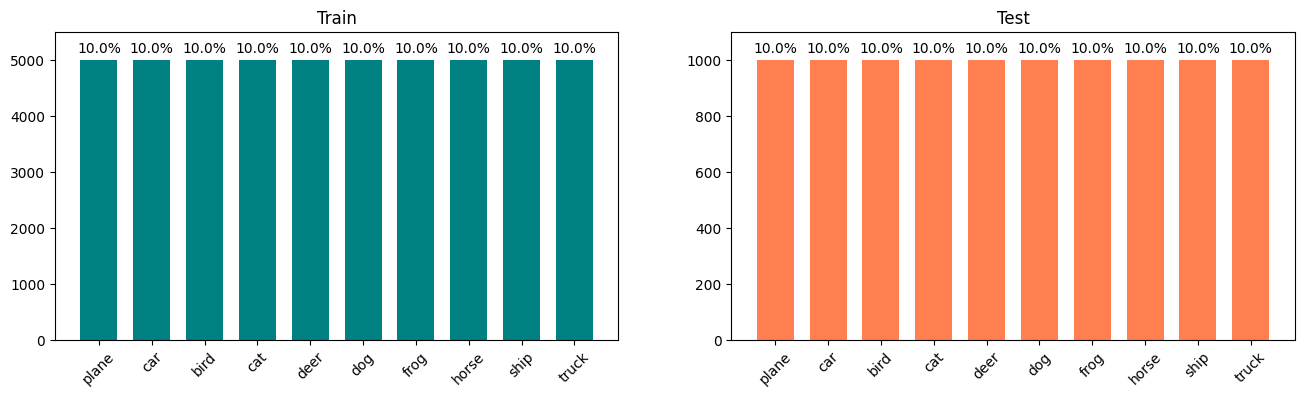

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [10]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [11]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [12]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

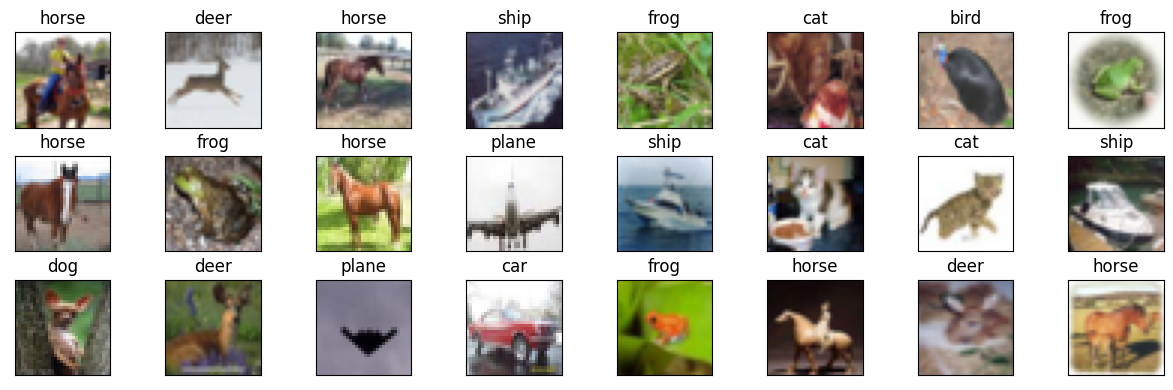

In [13]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [33]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

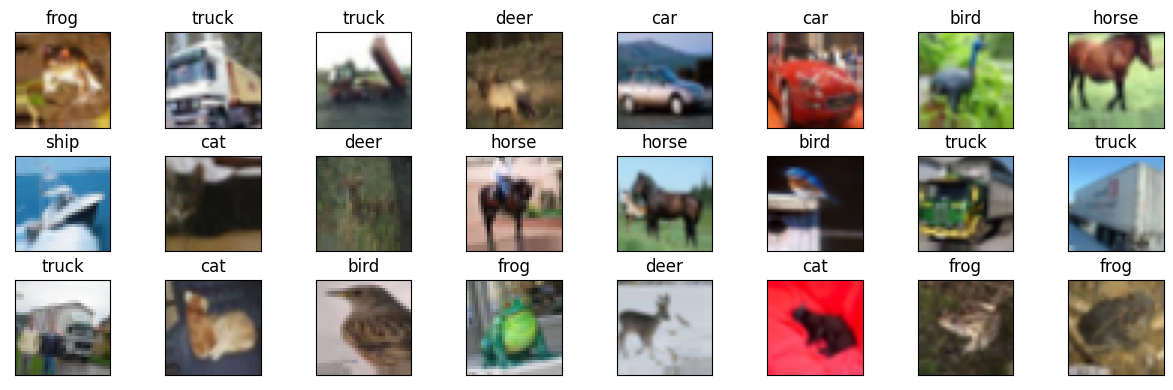

In [34]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

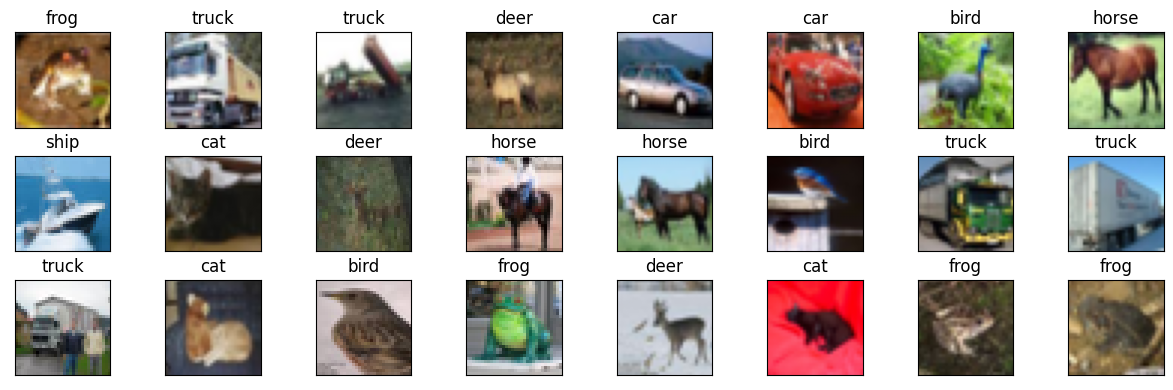

In [38]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [39]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [40]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


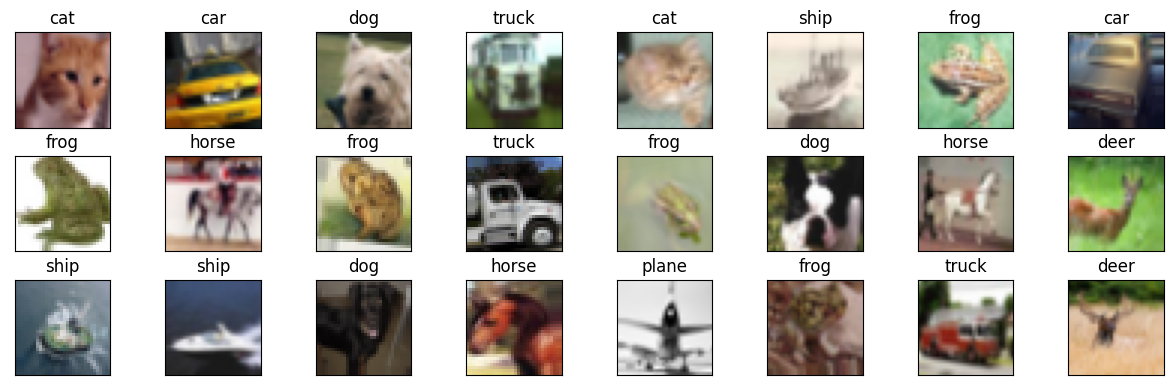

In [41]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images/255, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型



In [42]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

2022-08-11 06:54:08,712: INFO: model_params.mlp1.dropout=0.0
2022-08-11 06:54:08,713: INFO: model_params.mlp1.layer_count=1
2022-08-11 06:54:08,713: INFO: model_params.mlp1.units=128
2022-08-11 06:54:08,766: INFO: learning_rate=0.001
2022-08-11 06:54:08,767: INFO: model_params.mlp1.clip_value=None
2022-08-11 06:54:08,773: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               393344    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_____________________________________________________________

2022-08-11 06:54:08,787: INFO: model_params.mlp1.epochs=80
2022-08-11 06:54:08,787: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1, monitor=val_accuracy)
2022-08-11 06:54:08,788: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-11 06:54:08,789: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-11 06:54:08,789: INFO: use LearningRateScheduler()
2022-08-11 06:54:08,790: INFO: steps_per_epoch=1562
2022-08-11 06:54:08,791: INFO: start training
2022-08-11 06:54:08,791: INFO: use_class_weight=False


Epoch 1/80
1557/1562 [============================>.] - ETA: 0s - loss: 1.7699 - accuracy: 0.4046INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


2022-08-11 06:54:13,927: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7693 - accuracy: 0.4048 - val_loss: 1.5906 - val_accuracy: 0.4525 - lr: 0.0010
Epoch 2/80
1547/1562 [============================>.] - ETA: 0s - loss: 1.4853 - accuracy: 0.4817INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


2022-08-11 06:54:18,326: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 4s 3ms/step - loss: 1.4847 - accuracy: 0.4819 - val_loss: 1.5188 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 3/80
1549/1562 [============================>.] - ETA: 0s - loss: 1.4013 - accuracy: 0.5113INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


2022-08-11 06:54:22,705: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 4s 3ms/step - loss: 1.4008 - accuracy: 0.5115 - val_loss: 1.5267 - val_accuracy: 0.4770 - lr: 0.0010
Epoch 4/80
1550/1562 [============================>.] - ETA: 0s - loss: 1.3405 - accuracy: 0.5335INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


2022-08-11 06:54:27,071: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 4s 3ms/step - loss: 1.3401 - accuracy: 0.5338 - val_loss: 1.5209 - val_accuracy: 0.4854 - lr: 0.0010
Epoch 5/80
1562/1562 [==============================] - 4s 2ms/step - loss: 1.2859 - accuracy: 0.5551 - val_loss: 1.5484 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 6/80
1558/1562 [============================>.] - ETA: 0s - loss: 1.2364 - accuracy: 0.5728INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


2022-08-11 06:54:35,248: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 4s 3ms/step - loss: 1.2364 - accuracy: 0.5728 - val_loss: 1.5618 - val_accuracy: 0.4876 - lr: 0.0010
Epoch 7/80
1562/1562 [==============================] - 4s 2ms/step - loss: 1.1909 - accuracy: 0.5908 - val_loss: 1.5729 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 8/80
1551/1562 [============================>.] - ETA: 0s - loss: 1.1521 - accuracy: 0.6039INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


2022-08-11 06:54:43,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 4s 3ms/step - loss: 1.1519 - accuracy: 0.6040 - val_loss: 1.5913 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 9/80
1562/1562 [==============================] - 4s 2ms/step - loss: 1.1143 - accuracy: 0.6178 - val_loss: 1.6247 - val_accuracy: 0.4808 - lr: 0.0010
Epoch 10/80
1562/1562 [==============================] - 4s 2ms/step - loss: 1.0794 - accuracy: 0.6312 - val_loss: 1.6518 - val_accuracy: 0.4812 - lr: 0.0010
Epoch 11/80
1562/1562 [==============================] - 4s 2ms/step - loss: 1.0470 - accuracy: 0.6426 - val_loss: 1.6826 - val_accuracy: 0.4804 - lr: 0.0010
Epoch 12/80
1562/1562 [==============================] - 4s 2ms/step - loss: 1.0161 - accuracy: 0.6546 - val_loss: 1.7087 - val_accuracy: 0.4838 - lr: 0.0010
Epoch 13/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.9883 - accuracy: 0.6661 - val_loss: 1.7317 - val_accuracy: 0.4789 - lr: 0.0010
Epoch 14/80
1562/1562 [==============================] - 4s 2ms/s

2022-08-11 06:55:22,328: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1/assets


1562/1562 [==============================] - 4s 3ms/step - loss: 0.7833 - accuracy: 0.7295 - val_loss: 1.7383 - val_accuracy: 0.5024 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.7376 - accuracy: 0.7473 - val_loss: 1.7598 - val_accuracy: 0.5007 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.7141 - accuracy: 0.7573 - val_loss: 1.7830 - val_accuracy: 0.4981 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.6940 - accuracy: 0.7641 - val_loss: 1.8112 - val_accuracy: 0.4986 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.6754 - accuracy: 0.7711 -

Epoch 55/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.6355 - accuracy: 0.7833 - val_loss: 2.6394 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 56/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.6240 - accuracy: 0.7875 - val_loss: 2.6468 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 57/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.6058 - accuracy: 0.7958 - val_loss: 2.7606 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 58/80
1562/1562 [==============================] - 4s 2ms/step - loss: 0.5930 - accuracy: 0.8004 - val_loss: 2.7825 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 58: early stopping


2022-08-11 06:57:55,795: INFO: finish training [elapsed time: 227.00 seconds]


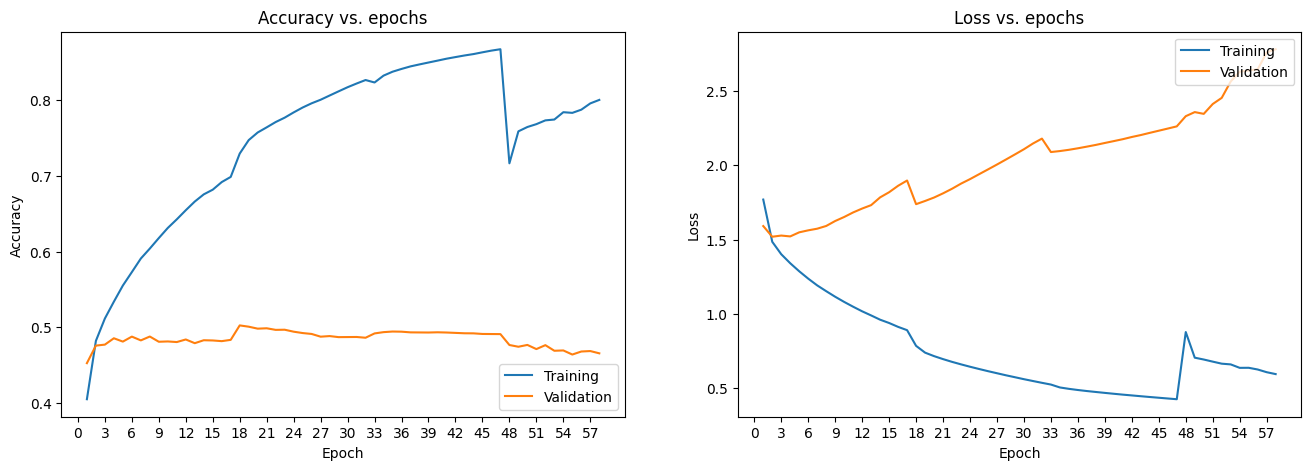

2022-08-11 06:57:56,210: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-11 06:58:05,758: INFO: test loss:1.7383
2022-08-11 06:58:05,759: INFO: test accuracy:0.5024
2022-08-11 06:58:05,760: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-11 06:58:05,762: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-11 06:58:05,762: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-11 06:58:05,763: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-11 06:58:05,764: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_50

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-11 06:58:07,285: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator


313/313 [==============================] - 2s 3ms/step


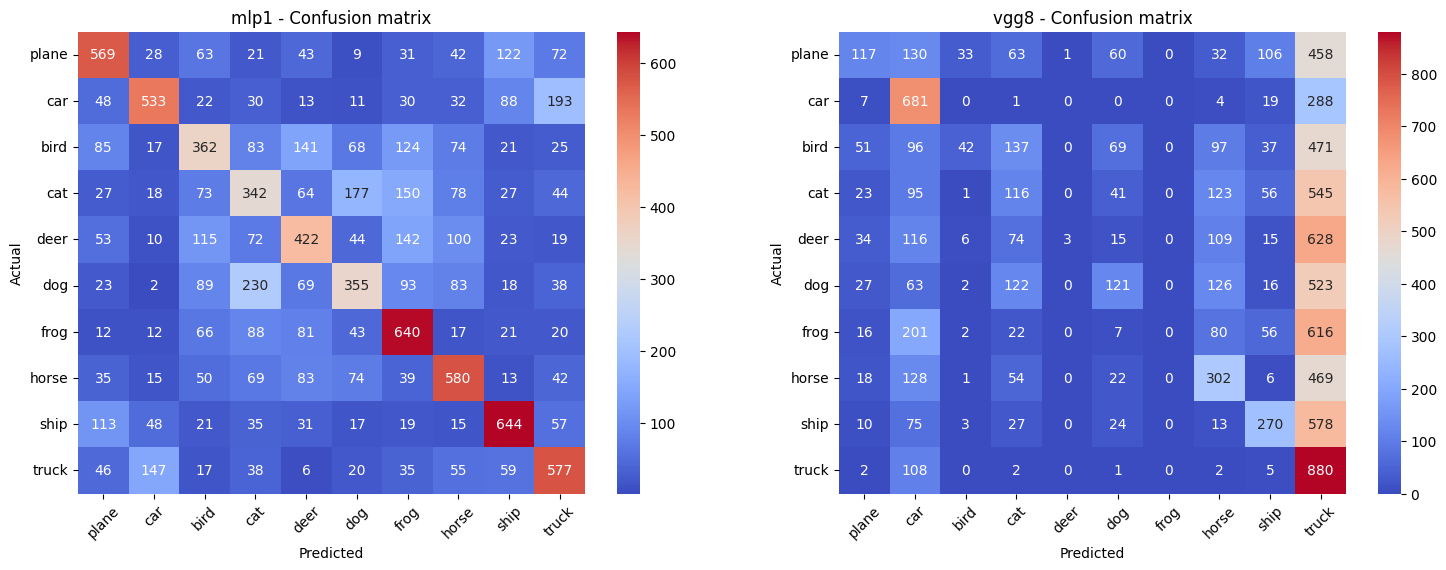

2022-08-11 06:58:11,921: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-11 06:58:13,386: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-11 06:58:13,390: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20
2022-08-11 06:58:17,862: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-11 06:58:17,868: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1
2022-08-11 06:58:18,766: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-11 06:58:18,770: INFO: loading model from /tf/eipi10/xuxiang

1/1 [==============================] - 0s 119ms/step


2022-08-11 06:58:21,409: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f648c4008b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


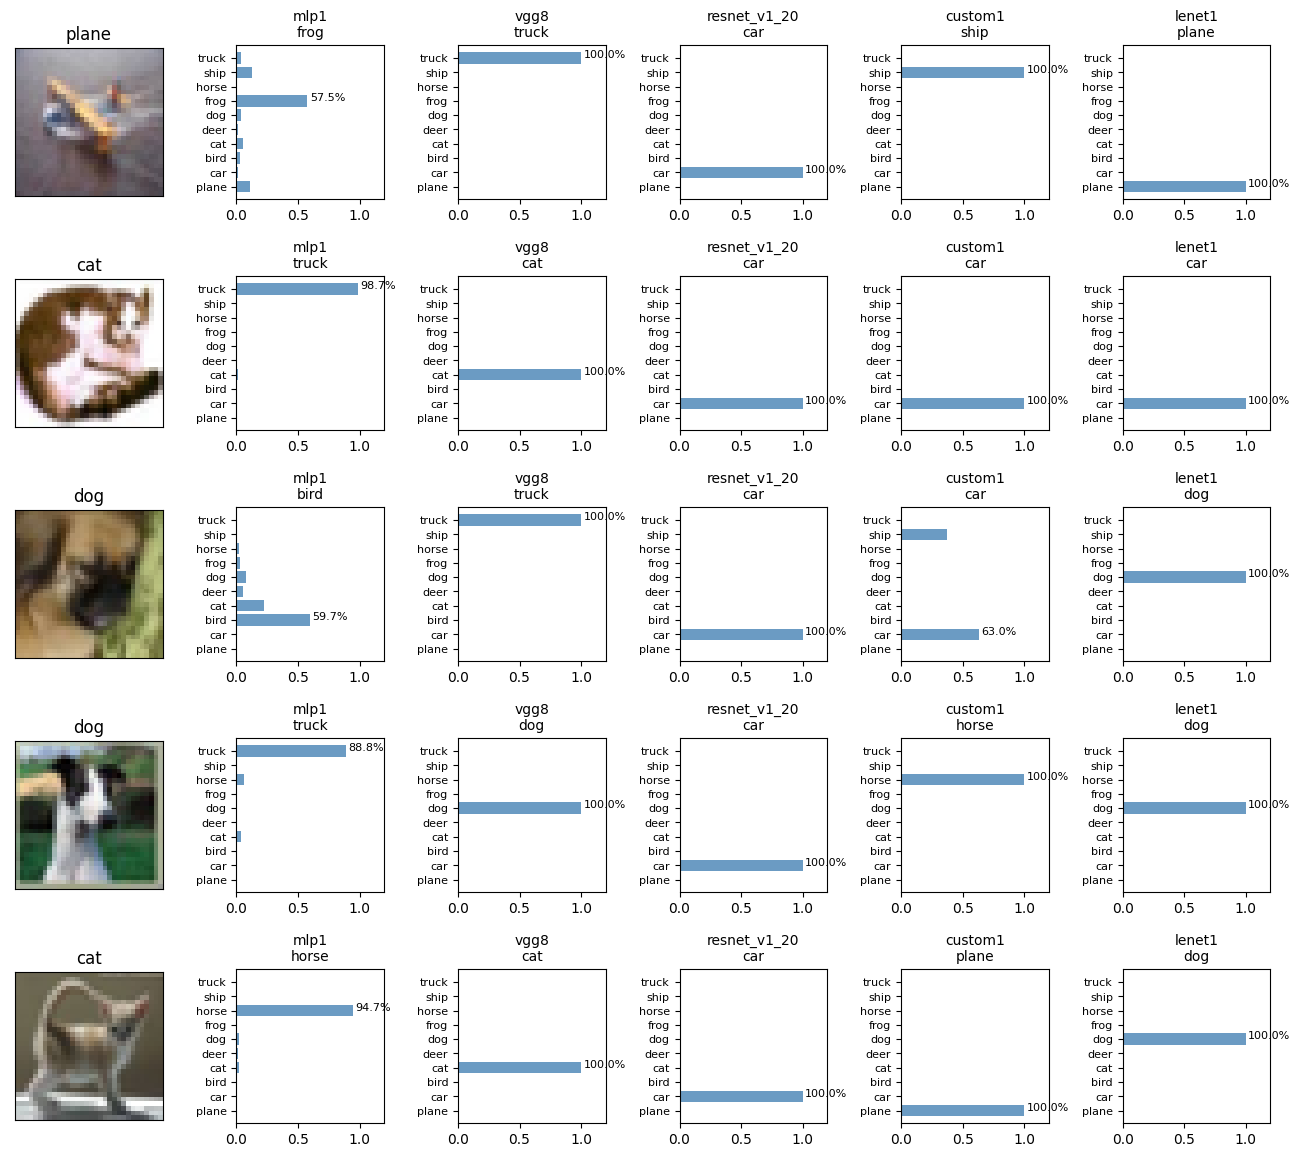

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
2  resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
3       custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
4        lenet1  cifar10_0808_count_5000.ipynb          83170       891.5   
5          mlp1  cifar10_0808_count_5000.ipynb         394634       227.0   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
2  2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
3  2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
4  2022-08-09 06:19      0.5087     0.8214          0.8290         0.7138   
5  2022-08-11 06:58      0.7866     1.7383          0.7270         0.5024   

   train_auc  test_auc  
1     1.0000    0.9919  
2     1.0000    0.9810  
3     0.9934    0.9776  
4     0.9847    0.9592  
5     0.9628    0.8760

In [45]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 06:04:23,684: INFO: model_params.lenet1.dropout=0.2
2022-08-09 06:04:23,765: INFO: learning_rate=0.001
2022-08-09 06:04:23,766: INFO: model_params.lenet1.clip_value=None
2022-08-09 06:04:23,772: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2022-08-09 06:04:23,800: INFO: model_params.lenet1.epochs=120
2022-08-09 06:04:23,801: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1, monitor=val_accuracy)
2022-08-09 06:04:23,802: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 06:04:23,803: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 06:04:23,803: INFO: use LearningRateScheduler()
2022-08-09 06:04:23,804: INFO: steps_per_epoch=1562
2022-08-09 06:04:23,804: INFO: start training
2022-08-09 06:04:23,805: INFO: use_class_weight=False


Epoch 1/120
1555/1562 [============================>.] - ETA: 0s - loss: 1.7374 - accuracy: 0.3725

2022-08-09 06:04:32,836: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:04:33,413: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.7362 - accuracy: 0.3730 - val_loss: 1.8515 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 2/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.4822 - accuracy: 0.4675

2022-08-09 06:04:41,596: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:04:42,160: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.4821 - accuracy: 0.4675 - val_loss: 1.4206 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 3/120
1555/1562 [============================>.] - ETA: 0s - loss: 1.3760 - accuracy: 0.5079

2022-08-09 06:04:50,226: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:04:50,794: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.3757 - accuracy: 0.5080 - val_loss: 1.3114 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 4/120
1562/1562 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.5351

2022-08-09 06:04:59,065: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:04:59,621: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.3075 - accuracy: 0.5351 - val_loss: 1.1747 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 5/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.2577 - accuracy: 0.5547 - val_loss: 1.2474 - val_accuracy: 0.5553 - lr: 0.0010
Epoch 6/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.2207 - accuracy: 0.5651

2022-08-09 06:05:15,298: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:05:15,867: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.2211 - accuracy: 0.5648 - val_loss: 1.1221 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 7/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.1913 - accuracy: 0.5746 - val_loss: 1.2270 - val_accuracy: 0.5618 - lr: 0.0010
Epoch 8/120
1557/1562 [============================>.] - ETA: 0s - loss: 1.1610 - accuracy: 0.5884

2022-08-09 06:05:30,934: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:05:31,495: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.1606 - accuracy: 0.5885 - val_loss: 1.0675 - val_accuracy: 0.6199 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.1333 - accuracy: 0.5984 - val_loss: 1.0799 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 10/120
1552/1562 [============================>.] - ETA: 0s - loss: 1.1197 - accuracy: 0.6016

2022-08-09 06:05:46,717: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:05:47,273: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.1194 - accuracy: 0.6017 - val_loss: 1.0436 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.1003 - accuracy: 0.6101 - val_loss: 1.0695 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0857 - accuracy: 0.6136 - val_loss: 1.0738 - val_accuracy: 0.6181 - lr: 0.0010
Epoch 13/120
1553/1562 [============================>.] - ETA: 0s - loss: 1.0645 - accuracy: 0.6231

2022-08-09 06:06:09,238: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:06:09,812: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0644 - accuracy: 0.6230 - val_loss: 0.9964 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0567 - accuracy: 0.6237 - val_loss: 1.0564 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0411 - accuracy: 0.6315 - val_loss: 0.9728 - val_accuracy: 0.6497 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0315 - accuracy: 0.6333 - val_loss: 1.0065 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 7s 5ms/step - loss: 1.0219 - accuracy: 0.6389 - val_loss: 1.0822 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 18/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.0174 - accuracy: 0.6399

2022-08-09 06:06:45,865: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:06:46,806: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0173 - accuracy: 0.6398 - val_loss: 0.9422 - val_accuracy: 0.6676 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0047 - accuracy: 0.6425 - val_loss: 0.9723 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.6439

2022-08-09 06:07:01,916: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:07:02,470: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0037 - accuracy: 0.6439 - val_loss: 0.9423 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 21/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9926 - accuracy: 0.6490 - val_loss: 0.9378 - val_accuracy: 0.6673 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9850 - accuracy: 0.6520 - val_loss: 1.0372 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 23/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.9777 - accuracy: 0.6549

2022-08-09 06:07:24,929: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:07:25,510: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9778 - accuracy: 0.6549 - val_loss: 0.9194 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9716 - accuracy: 0.6544 - val_loss: 0.9492 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9668 - accuracy: 0.6573 - val_loss: 1.0952 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9655 - accuracy: 0.6575 - val_loss: 0.9360 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9568 - accuracy: 0.6614 - val_loss: 0.9336 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 28/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.9489 - accuracy: 0.6637

2022-08-09 06:08:01,583: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:08:02,133: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9493 - accuracy: 0.6636 - val_loss: 0.9011 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9468 - accuracy: 0.6647 - val_loss: 0.9695 - val_accuracy: 0.6619 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9472 - accuracy: 0.6652 - val_loss: 0.9858 - val_accuracy: 0.6549 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9461 - accuracy: 0.6669 - val_loss: 1.0034 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 32/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9342 - accuracy: 0.6692 - val_loss: 0.9213 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 33/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9296 - accuracy: 0.6707 - val_loss: 0.9389 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 7

2022-08-09 06:08:59,575: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:09:00,135: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9194 - accuracy: 0.6760 - val_loss: 0.9075 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9188 - accuracy: 0.6754 - val_loss: 0.9530 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9171 - accuracy: 0.6752 - val_loss: 0.9187 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 39/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9082 - accuracy: 0.6782 - val_loss: 0.9603 - val_accuracy: 0.6618 - lr: 0.0010
Epoch 40/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9010 - accuracy: 0.6797 - val_loss: 1.0411 - val_accuracy: 0.6368 - lr: 0.0010
Epoch 41/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9038 - accuracy: 0.6803 - val_loss: 1.1486 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 42/120
1560/1562 [============================>.] - E

2022-08-09 06:09:43,834: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:09:44,412: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9026 - accuracy: 0.6812 - val_loss: 0.8918 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 43/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9035 - accuracy: 0.6798 - val_loss: 0.9889 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 44/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8951 - accuracy: 0.6808 - val_loss: 0.9416 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 45/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8984 - accuracy: 0.6822 - val_loss: 0.9028 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 46/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8961 - accuracy: 0.6814 - val_loss: 1.1850 - val_accuracy: 0.5975 - lr: 0.0010
Epoch 47/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8858 - accuracy: 0.6862 - val_loss: 0.9298 - val_accuracy: 0.6723 - lr: 0.0010
Epoch 48/120
1562/1562 [==============================] - 7

2022-08-09 06:10:55,409: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:10:55,964: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8816 - accuracy: 0.6884 - val_loss: 0.8687 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 53/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8764 - accuracy: 0.6892 - val_loss: 0.8776 - val_accuracy: 0.6904 - lr: 0.0010
Epoch 54/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8714 - accuracy: 0.6912 - val_loss: 0.8700 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 55/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8734 - accuracy: 0.6927 - val_loss: 0.8764 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 56/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8644 - accuracy: 0.6944 - val_loss: 1.0338 - val_accuracy: 0.6402 - lr: 0.0010
Epoch 57/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.8620 - accuracy: 0.6930

2022-08-09 06:11:32,018: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:11:32,569: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8617 - accuracy: 0.6932 - val_loss: 0.8608 - val_accuracy: 0.6967 - lr: 0.0010
Epoch 58/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8607 - accuracy: 0.6939 - val_loss: 0.9125 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 59/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8587 - accuracy: 0.6966 - val_loss: 0.9801 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 60/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8558 - accuracy: 0.6957 - val_loss: 0.8717 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/120
1550/1562 [============================>.] - ETA: 0s - loss: 0.8188 - accuracy: 0.7101

2022-08-09 06:12:01,448: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:12:01,990: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8190 - accuracy: 0.7101 - val_loss: 0.8470 - val_accuracy: 0.7064 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8096 - accuracy: 0.7130 - val_loss: 0.8544 - val_accuracy: 0.7043 - lr: 1.0000e-04
Epoch 63/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.8071 - accuracy: 0.7152

2022-08-09 06:12:17,260: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:12:18,203: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8070 - accuracy: 0.7151 - val_loss: 0.8419 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 64/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.8068 - accuracy: 0.7145

2022-08-09 06:12:26,422: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:12:26,996: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8069 - accuracy: 0.7144 - val_loss: 0.8385 - val_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 65/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.8059 - accuracy: 0.7145

2022-08-09 06:12:35,284: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:12:35,841: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8061 - accuracy: 0.7144 - val_loss: 0.8373 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8037 - accuracy: 0.7167 - val_loss: 0.8434 - val_accuracy: 0.7087 - lr: 1.0000e-04
Epoch 67/120
1554/1562 [============================>.] - ETA: 0s - loss: 0.7995 - accuracy: 0.7180

2022-08-09 06:12:50,987: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:12:51,547: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7998 - accuracy: 0.7178 - val_loss: 0.8423 - val_accuracy: 0.7097 - lr: 1.0000e-04
Epoch 68/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7984 - accuracy: 0.7199 - val_loss: 0.8330 - val_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 69/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7963 - accuracy: 0.7179 - val_loss: 0.8470 - val_accuracy: 0.7072 - lr: 1.0000e-04
Epoch 70/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.7958 - accuracy: 0.7181

2022-08-09 06:13:13,460: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:13:14,013: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7961 - accuracy: 0.7180 - val_loss: 0.8349 - val_accuracy: 0.7098 - lr: 1.0000e-04
Epoch 71/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7986 - accuracy: 0.7185 - val_loss: 0.8489 - val_accuracy: 0.7049 - lr: 1.0000e-04
Epoch 72/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8009 - accuracy: 0.7152 - val_loss: 0.8378 - val_accuracy: 0.7089 - lr: 1.0000e-04
Epoch 73/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.7918 - accuracy: 0.7195

2022-08-09 06:13:36,861: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:13:37,445: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7919 - accuracy: 0.7194 - val_loss: 0.8353 - val_accuracy: 0.7106 - lr: 1.0000e-04
Epoch 74/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7955 - accuracy: 0.7193 - val_loss: 0.8359 - val_accuracy: 0.7101 - lr: 1.0000e-04
Epoch 75/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.7899 - accuracy: 0.7176

2022-08-09 06:13:52,795: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:13:53,381: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7900 - accuracy: 0.7176 - val_loss: 0.8306 - val_accuracy: 0.7116 - lr: 1.0000e-04
Epoch 76/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.7931 - accuracy: 0.7203

2022-08-09 06:14:01,483: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:14:02,059: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7930 - accuracy: 0.7204 - val_loss: 0.8300 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 77/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7949 - accuracy: 0.7187 - val_loss: 0.8311 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 78/120
1554/1562 [============================>.] - ETA: 0s - loss: 0.7879 - accuracy: 0.7196

2022-08-09 06:14:17,317: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:14:17,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7881 - accuracy: 0.7195 - val_loss: 0.8289 - val_accuracy: 0.7129 - lr: 1.0000e-04
Epoch 79/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7901 - accuracy: 0.7221 - val_loss: 0.8368 - val_accuracy: 0.7097 - lr: 1.0000e-04
Epoch 80/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7869 - accuracy: 0.7236 - val_loss: 0.8278 - val_accuracy: 0.7106 - lr: 1.0000e-04
Epoch 81/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7894 - accuracy: 0.7204 - val_loss: 0.8235 - val_accuracy: 0.7127 - lr: 1.0000e-04
Epoch 82/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7886 - accuracy: 0.7223 - val_loss: 0.8446 - val_accuracy: 0.7088 - lr: 1.0000e-04
Epoch 83/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.7858 - accuracy: 0.7227

2022-08-09 06:14:54,010: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:14:54,568: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7856 - accuracy: 0.7228 - val_loss: 0.8223 - val_accuracy: 0.7136 - lr: 1.0000e-04
Epoch 84/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7872 - accuracy: 0.7195 - val_loss: 0.8271 - val_accuracy: 0.7117 - lr: 1.0000e-04
Epoch 85/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7826 - accuracy: 0.7219 - val_loss: 0.8366 - val_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 86/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7867 - accuracy: 0.7217 - val_loss: 0.8340 - val_accuracy: 0.7093 - lr: 1.0000e-04
Epoch 87/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7796 - accuracy: 0.7231 - val_loss: 0.8246 - val_accuracy: 0.7134 - lr: 1.0000e-04
Epoch 88/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7835 - accuracy: 0.7221 - val_loss: 0.8298 - val_accuracy: 0.7099 - lr: 1.0000e-04
Epoch 89/120
1559/1562 [===========

2022-08-09 06:15:38,612: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


2022-08-09 06:15:39,213: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7780 - accuracy: 0.7238 - val_loss: 0.8214 - val_accuracy: 0.7138 - lr: 1.0000e-04
Epoch 90/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7816 - accuracy: 0.7234 - val_loss: 0.8292 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 0.0001.
Epoch 91/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7864 - accuracy: 0.7198 - val_loss: 0.8238 - val_accuracy: 0.7115 - lr: 1.0000e-05
Epoch 92/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7864 - accuracy: 0.7217 - val_loss: 0.8244 - val_accuracy: 0.7123 - lr: 1.0000e-05
Epoch 93/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7761 - accuracy: 0.7249 - val_loss: 0.8251 - val_accuracy: 0.7117 - lr: 1.0000e-05
Epoch 94/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7725 - accuracy: 0.7247 - val_loss: 0

2022-08-09 06:19:15,280: INFO: finish training [elapsed time: 891.48 seconds]


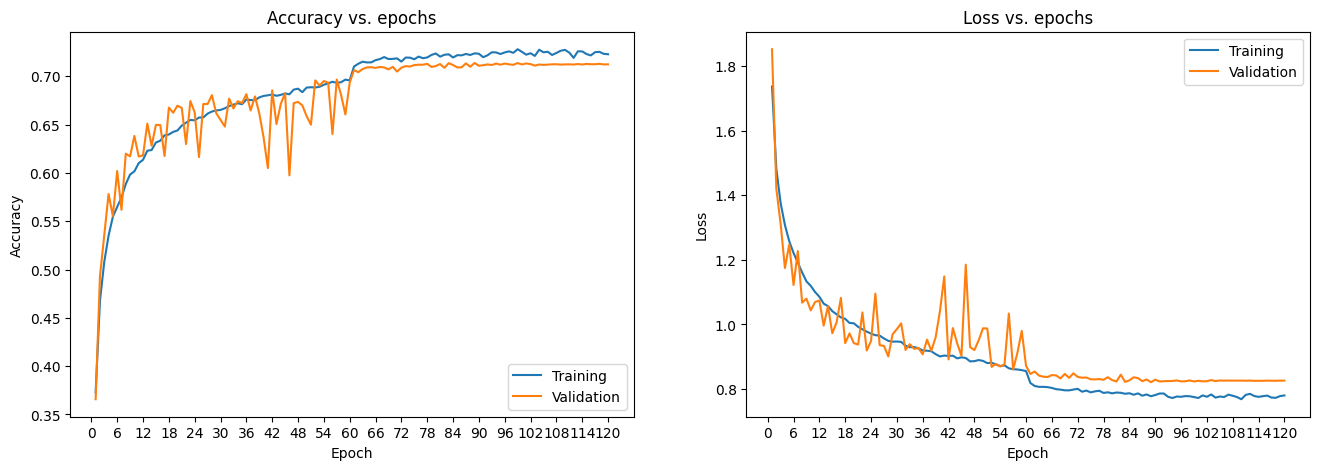

2022-08-09 06:19:15,702: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 06:19:34,836: INFO: test loss:0.8214
2022-08-09 06:19:34,837: INFO: test accuracy:0.7138
2022-08-09 06:19:34,839: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 06:19:34,840: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 06:19:34,841: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:19:34,842: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:19:34,843: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_50

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 06:19:35,126: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator


313/313 [==============================] - 1s 2ms/step


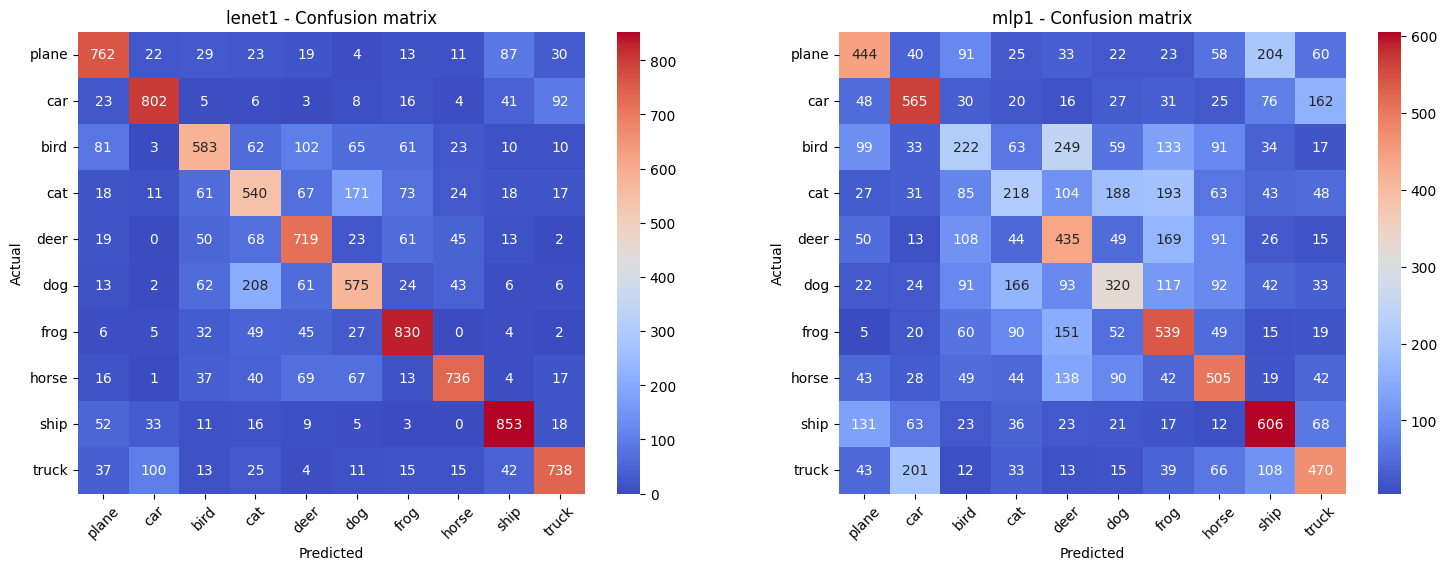

2022-08-09 06:19:39,422: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-09 06:19:39,706: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:19:39,708: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20
2022-08-09 06:19:44,379: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:19:44,382: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1
2022-08-09 06:19:45,294: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:19:45,296: INFO: loading model from /tf/eipi10/xuxiang

1/1 [==============================] - 0s 101ms/step


2022-08-09 06:19:49,317: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f7bdc473e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 11ms/step


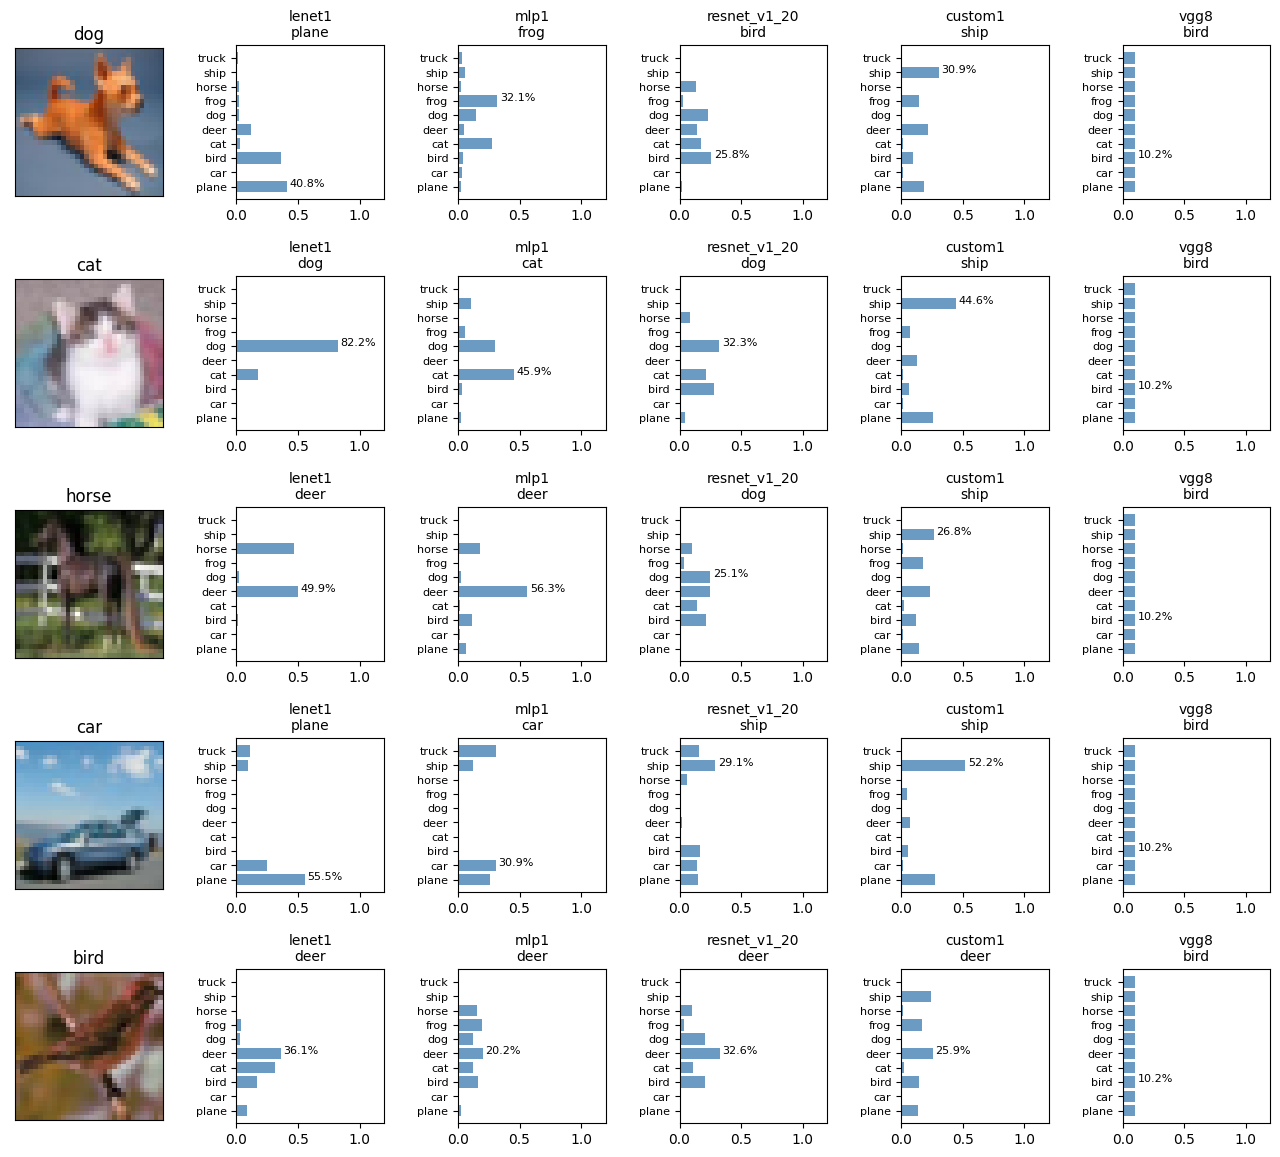

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1        lenet1  cifar10_0808_count_5000.ipynb          83170       891.5   
2          mlp1  cifar10_0808_count_5000.ipynb         394634       514.8   
3  resnet_v1_20  cifar10_0808_count_5000.ipynb         273066        19.4   
4       custom1  cifar10_0808_count_5000.ipynb          73738         5.8   
5          vgg8  cifar10_0808_count_5000.ipynb        1672906         8.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 06:19      0.5087     0.8214          0.8290         0.7138   
2  2022-08-09 06:03      1.4713     1.5869          0.4797         0.4324   
3  2022-08-09 05:40      2.5314     2.5575          0.2298         0.2252   
4  2022-08-09 05:39      3.4464     3.4333          0.1194         0.1189   
5  2022-08-09 05:40      2.3024     2.3027          0.1054         0.1000   

   train_auc  test_auc  
1     0.9847    0.9592  
2     0.8724    0.8477  
3     0.7653    0.7629  
4     0.6965    0.6950  
5     0.5000    0.5000

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 06:19:53,495: INFO: model_params.custom1.dropout=0.2
2022-08-09 06:19:53,595: INFO: learning_rate=0.001
2022-08-09 06:19:53,596: INFO: model_params.custom1.clip_value=None
2022-08-09 06:19:53,602: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2022-08-09 06:19:53,644: INFO: model_params.custom1.epochs=120
2022-08-09 06:19:53,645: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1, monitor=val_accuracy)
2022-08-09 06:19:53,646: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 06:19:53,646: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 06:19:53,647: INFO: use LearningRateScheduler()
2022-08-09 06:19:53,648: INFO: steps_per_epoch=1562
2022-08-09 06:19:53,649: INFO: start training
2022-08-09 06:19:53,650: INFO: use_class_weight=False


Epoch 1/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.6165 - accuracy: 0.4181

2022-08-09 06:20:03,814: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:20:04,460: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 11s 6ms/step - loss: 1.6160 - accuracy: 0.4183 - val_loss: 1.8249 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 2/120
1556/1562 [============================>.] - ETA: 0s - loss: 1.2658 - accuracy: 0.5484

2022-08-09 06:20:13,752: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:20:14,723: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 1.2650 - accuracy: 0.5488 - val_loss: 1.3082 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 3/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1318 - accuracy: 0.5989 - val_loss: 1.5585 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 4/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0486 - accuracy: 0.6280 - val_loss: 1.4132 - val_accuracy: 0.5116 - lr: 0.0010
Epoch 5/120
1551/1562 [============================>.] - ETA: 0s - loss: 0.9911 - accuracy: 0.6529

2022-08-09 06:20:40,319: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:20:40,966: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.9910 - accuracy: 0.6531 - val_loss: 0.9948 - val_accuracy: 0.6489 - lr: 0.0010
Epoch 6/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9428 - accuracy: 0.6694 - val_loss: 1.1169 - val_accuracy: 0.6034 - lr: 0.0010
Epoch 7/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9045 - accuracy: 0.6816 - val_loss: 1.1323 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8764 - accuracy: 0.6919 - val_loss: 1.2439 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8568 - accuracy: 0.6975 - val_loss: 1.0492 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8396 - accuracy: 0.7074 - val_loss: 1.4328 - val_accuracy: 0.5435 - lr: 0.0010
Epoch 11/120
1559/1562 [============================>.] - ETA:

2022-08-09 06:21:29,734: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:21:30,351: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.8211 - accuracy: 0.7114 - val_loss: 0.8894 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8126 - accuracy: 0.7142 - val_loss: 1.0668 - val_accuracy: 0.6373 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7954 - accuracy: 0.7229 - val_loss: 0.9164 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 14/120
1551/1562 [============================>.] - ETA: 0s - loss: 0.7777 - accuracy: 0.7266

2022-08-09 06:21:55,117: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:21:55,766: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7774 - accuracy: 0.7267 - val_loss: 0.8316 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7688 - accuracy: 0.7301 - val_loss: 0.9758 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 16/120
1553/1562 [============================>.] - ETA: 0s - loss: 0.7637 - accuracy: 0.7312

2022-08-09 06:22:12,856: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:22:13,886: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7638 - accuracy: 0.7311 - val_loss: 0.8090 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7472 - accuracy: 0.7391 - val_loss: 0.8842 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 18/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7478 - accuracy: 0.7376 - val_loss: 0.9521 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7352 - accuracy: 0.7422 - val_loss: 1.0683 - val_accuracy: 0.6498 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7298 - accuracy: 0.7432 - val_loss: 0.9580 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 21/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.7213 - accuracy: 0.7493

2022-08-09 06:22:54,662: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:22:55,282: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7213 - accuracy: 0.7494 - val_loss: 0.7593 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7162 - accuracy: 0.7500 - val_loss: 1.0258 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7121 - accuracy: 0.7519 - val_loss: 1.0702 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7531

2022-08-09 06:23:20,126: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:23:20,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7046 - accuracy: 0.7531 - val_loss: 0.7035 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6982 - accuracy: 0.7552 - val_loss: 1.0626 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6925 - accuracy: 0.7578 - val_loss: 0.7709 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6980 - accuracy: 0.7559 - val_loss: 0.7746 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6793 - accuracy: 0.7619 - val_loss: 0.8335 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6819 - accuracy: 0.7615 - val_loss: 0.7979 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 

2022-08-09 06:24:58,594: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:24:59,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.6565 - accuracy: 0.7689 - val_loss: 0.7140 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6568 - accuracy: 0.7698 - val_loss: 0.8060 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6530 - accuracy: 0.7709 - val_loss: 0.7373 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 39/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.7723
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6502 - accuracy: 0.7723 - val_loss: 1.0150 - val_accuracy: 0.6778 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
1556/1562 [============================>.] - ETA: 0s - loss: 0.6089 - accuracy: 0.7859

2022-08-09 06:25:32,938: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:25:33,606: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.6088 - accuracy: 0.7860 - val_loss: 0.7074 - val_accuracy: 0.7646 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.6000 - accuracy: 0.7864

2022-08-09 06:25:42,860: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:25:43,511: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5997 - accuracy: 0.7866 - val_loss: 0.6506 - val_accuracy: 0.7823 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5933 - accuracy: 0.7889 - val_loss: 0.6558 - val_accuracy: 0.7798 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/120
1553/1562 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.7927

2022-08-09 06:26:00,840: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:26:01,487: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5898 - accuracy: 0.7929 - val_loss: 0.6300 - val_accuracy: 0.7865 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5906 - accuracy: 0.7928 - val_loss: 0.6860 - val_accuracy: 0.7737 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5901 - accuracy: 0.7938 - val_loss: 0.7081 - val_accuracy: 0.7636 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5872 - accuracy: 0.7919 - val_loss: 0.6993 - val_accuracy: 0.7683 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.7954

2022-08-09 06:26:34,436: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:26:35,061: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5835 - accuracy: 0.7952 - val_loss: 0.6315 - val_accuracy: 0.7870 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5843 - accuracy: 0.7951 - val_loss: 0.7114 - val_accuracy: 0.7661 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5747 - accuracy: 0.7979 - val_loss: 0.6772 - val_accuracy: 0.7784 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5779 - accuracy: 0.7945 - val_loss: 0.6685 - val_accuracy: 0.7777 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5704 - accuracy: 0.7

2022-08-09 06:27:55,816: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:27:56,500: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.5687 - accuracy: 0.7981 - val_loss: 0.6404 - val_accuracy: 0.7871 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.5659 - accuracy: 0.8011
Epoch 58: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5658 - accuracy: 0.8013 - val_loss: 0.6684 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.5498 - accuracy: 0.8072

2022-08-09 06:28:13,596: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:28:14,245: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5500 - accuracy: 0.8069 - val_loss: 0.6242 - val_accuracy: 0.7919 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.5548 - accuracy: 0.8061

2022-08-09 06:28:23,434: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:28:24,081: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5547 - accuracy: 0.8062 - val_loss: 0.6084 - val_accuracy: 0.7954 - lr: 1.0000e-04
Epoch 61/120
1556/1562 [============================>.] - ETA: 0s - loss: 0.5545 - accuracy: 0.8046

2022-08-09 06:28:33,285: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


2022-08-09 06:28:33,920: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5546 - accuracy: 0.8046 - val_loss: 0.6073 - val_accuracy: 0.7981 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5512 - accuracy: 0.8068 - val_loss: 0.6040 - val_accuracy: 0.7974 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5475 - accuracy: 0.8078 - val_loss: 0.6187 - val_accuracy: 0.7946 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5493 - accuracy: 0.8051 - val_loss: 0.6126 - val_accuracy: 0.7972 - lr: 1.0000e-04
Epoch 65/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5484 - accuracy: 0.8058 - val_loss: 0.6034 - val_accuracy: 0.7971 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5441 - accuracy: 0.8089 - val_loss: 0.6251 - val_accuracy: 0.7904 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==========

2022-08-09 06:33:50,519: INFO: finish training [elapsed time: 836.87 seconds]


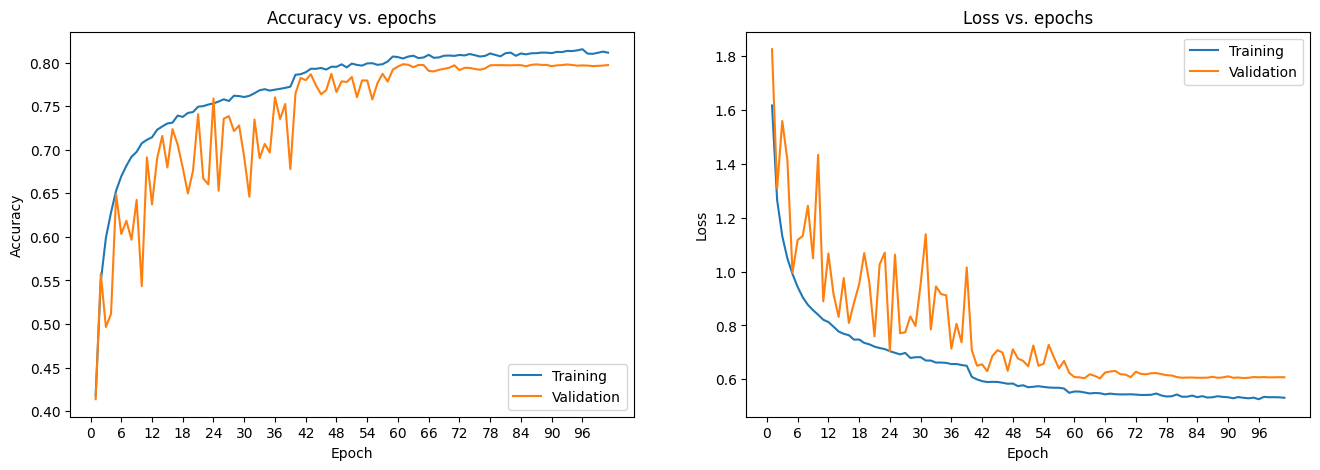

2022-08-09 06:33:50,916: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 06:34:11,356: INFO: test loss:0.6073
2022-08-09 06:34:11,356: INFO: test accuracy:0.7981
2022-08-09 06:34:11,358: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 06:34:11,359: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 06:34:11,360: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:34:11,361: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:34:11,362: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_50

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 06:34:12,179: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator


313/313 [==============================] - 1s 2ms/step


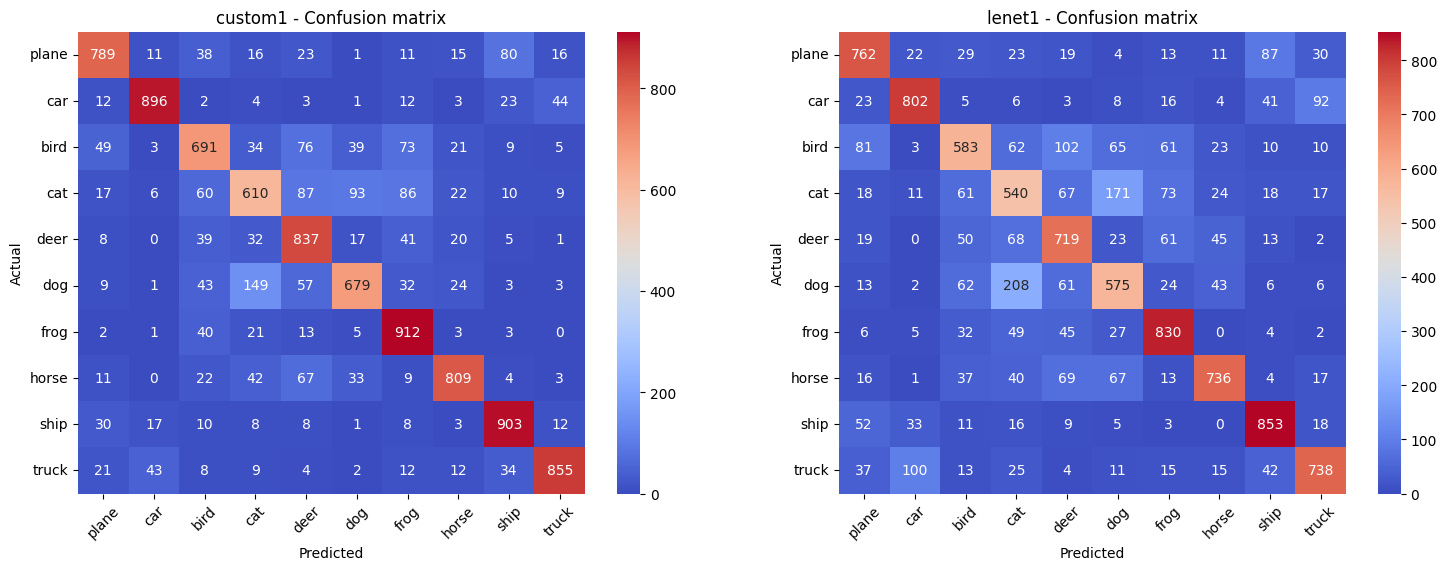

2022-08-09 06:34:16,744: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 06:34:17,534: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:34:17,537: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1
2022-08-09 06:34:17,819: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:34:17,821: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20
2022-08-09 06:34:22,570: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 06:34:22,577: INFO: loading model from /tf/eipi10/xuxiangwen

1/1 [==============================] - 0s 10ms/step


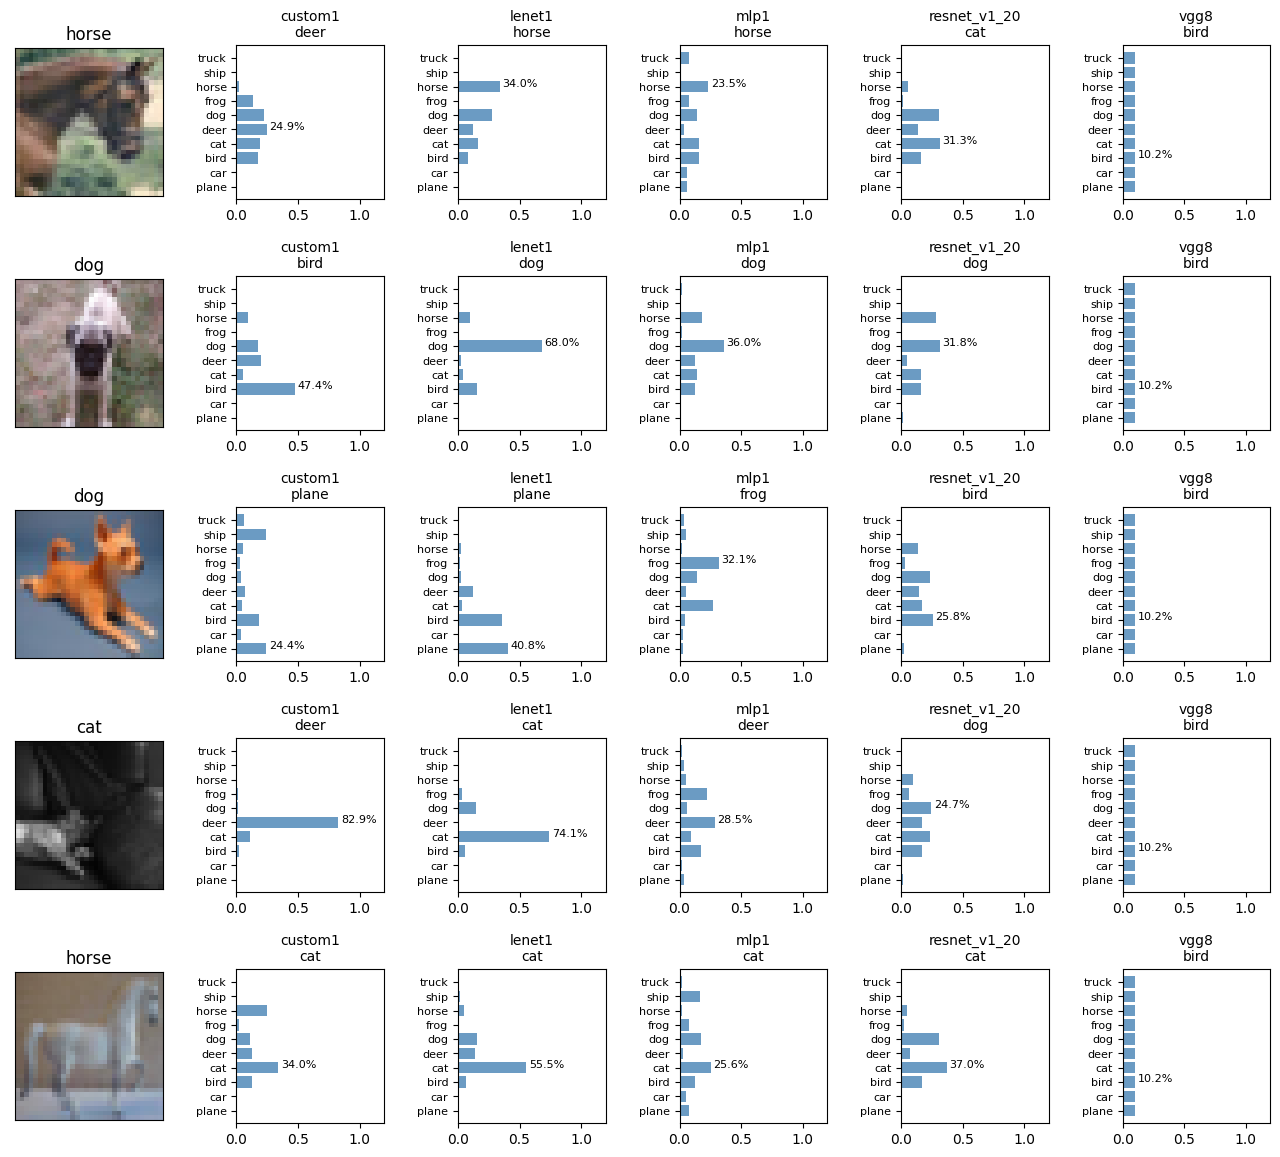

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
2        lenet1  cifar10_0808_count_5000.ipynb          83170       891.5   
3          mlp1  cifar10_0808_count_5000.ipynb         394634       514.8   
4  resnet_v1_20  cifar10_0808_count_5000.ipynb         273066        19.4   
5          vgg8  cifar10_0808_count_5000.ipynb        1672906         8.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
2  2022-08-09 06:19      0.5087     0.8214          0.8290         0.7138   
3  2022-08-09 06:03      1.4713     1.5869          0.4797         0.4324   
4  2022-08-09 05:40      2.5314     2.5575          0.2298         0.2252   
5  2022-08-09 05:40      2.3024     2.3027          0.1054         0.1000   

   train_auc  test_auc  
1     0.9934    0.9776  
2     0.9847    0.9592  
3     0.8724    0.8477  
4     0.7653    0.7629  
5     0.5000    0.5000

In [22]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 06:34:30,931: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 06:34:31,092: INFO: learning_rate=0.001
2022-08-09 06:34:31,092: INFO: model_params.vgg8.clip_value=None
2022-08-09 06:34:31,098: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 06:34:31,148: INFO: model_params.vgg8.epochs=120
2022-08-09 06:34:31,148: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8, monitor=val_accuracy)
2022-08-09 06:34:31,149: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 06:34:31,150: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 06:34:31,150: INFO: use LearningRateScheduler()
2022-08-09 06:34:31,151: INFO: steps_per_epoch=1562
2022-08-09 06:34:31,152: INFO: start training
2022-08-09 06:34:31,152: INFO: use_class_weight=False


Epoch 1/120
1562/1562 [==============================] - ETA: 0s - loss: 2.1779 - accuracy: 0.1588

2022-08-09 06:34:51,289: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:34:52,312: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 2.1779 - accuracy: 0.1588 - val_loss: 2.0499 - val_accuracy: 0.2084 - lr: 0.0010
Epoch 2/120
1562/1562 [==============================] - 16s 10ms/step - loss: 2.0663 - accuracy: 0.1781 - val_loss: 2.0649 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 3/120
1561/1562 [============================>.] - ETA: 0s - loss: 2.0089 - accuracy: 0.1913

2022-08-09 06:35:27,303: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:35:28,857: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 2.0088 - accuracy: 0.1913 - val_loss: 1.8345 - val_accuracy: 0.2453 - lr: 0.0010
Epoch 4/120
1557/1562 [============================>.] - ETA: 0s - loss: 1.9311 - accuracy: 0.2292

2022-08-09 06:35:47,606: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:35:48,659: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.9307 - accuracy: 0.2295 - val_loss: 1.8345 - val_accuracy: 0.2880 - lr: 0.0010
Epoch 5/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.8627 - accuracy: 0.2614

2022-08-09 06:36:07,409: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:36:08,442: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.8620 - accuracy: 0.2616 - val_loss: 1.6091 - val_accuracy: 0.3792 - lr: 0.0010
Epoch 6/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.7628 - accuracy: 0.3081

2022-08-09 06:36:27,571: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:36:28,645: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.7628 - accuracy: 0.3081 - val_loss: 1.4848 - val_accuracy: 0.4214 - lr: 0.0010
Epoch 7/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.6848 - accuracy: 0.3429

2022-08-09 06:36:47,267: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:36:48,310: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.6845 - accuracy: 0.3431 - val_loss: 1.3980 - val_accuracy: 0.4729 - lr: 0.0010
Epoch 8/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.5450 - accuracy: 0.4019

2022-08-09 06:37:07,330: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:37:08,423: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.5449 - accuracy: 0.4022 - val_loss: 1.2688 - val_accuracy: 0.5201 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 16s 11ms/step - loss: 1.3547 - accuracy: 0.4863 - val_loss: 1.3973 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 10/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.2093 - accuracy: 0.5454

2022-08-09 06:37:43,550: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:37:44,622: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.2090 - accuracy: 0.5454 - val_loss: 1.3741 - val_accuracy: 0.6043 - lr: 0.0010
Epoch 11/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.0612 - accuracy: 0.6098

2022-08-09 06:38:03,223: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:38:04,691: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 1.0611 - accuracy: 0.6098 - val_loss: 1.4078 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 12/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.6682

2022-08-09 06:38:23,364: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:38:24,414: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.9257 - accuracy: 0.6682 - val_loss: 0.8111 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 13/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.8159 - accuracy: 0.7162

2022-08-09 06:38:43,034: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:38:44,083: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.8161 - accuracy: 0.7161 - val_loss: 0.7936 - val_accuracy: 0.7384 - lr: 0.0010
Epoch 14/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.7331 - accuracy: 0.7443

2022-08-09 06:39:03,242: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:39:04,324: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.7331 - accuracy: 0.7443 - val_loss: 0.6960 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.6632 - accuracy: 0.7727 - val_loss: 0.7050 - val_accuracy: 0.7674 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.6105 - accuracy: 0.7895 - val_loss: 0.9570 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5652 - accuracy: 0.8054 - val_loss: 0.8157 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 18/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.5313 - accuracy: 0.8190

2022-08-09 06:40:12,245: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:40:13,308: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.5315 - accuracy: 0.8190 - val_loss: 0.6784 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5010 - accuracy: 0.8298 - val_loss: 0.8719 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 20/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.8381

2022-08-09 06:40:48,848: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:40:49,991: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.4700 - accuracy: 0.8381 - val_loss: 0.6522 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 21/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.4468 - accuracy: 0.8477 - val_loss: 0.7058 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 22/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.4242 - accuracy: 0.8549

2022-08-09 06:41:25,191: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:41:26,238: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.4240 - accuracy: 0.8550 - val_loss: 0.6244 - val_accuracy: 0.8119 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.4054 - accuracy: 0.8599 - val_loss: 0.6876 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 24/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.8686

2022-08-09 06:42:01,484: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:42:02,517: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.3850 - accuracy: 0.8685 - val_loss: 0.5883 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8753

2022-08-09 06:42:21,620: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:42:22,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.3640 - accuracy: 0.8753 - val_loss: 0.5824 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 26/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.8804

2022-08-09 06:42:41,433: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:42:42,485: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.3492 - accuracy: 0.8804 - val_loss: 0.5702 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 27/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8842

2022-08-09 06:43:01,604: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:43:02,653: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.3371 - accuracy: 0.8841 - val_loss: 0.5128 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.3218 - accuracy: 0.8907 - val_loss: 0.5508 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.3079 - accuracy: 0.8944 - val_loss: 0.5717 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.3044 - accuracy: 0.8957 - val_loss: 0.5683 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.2832 - accuracy: 0.9018 - val_loss: 0.6030 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 32/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.2785 - accuracy: 0.9043 - val_loss: 0.6028 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 33/120
1558/1562 [=======================

2022-08-09 06:44:43,214: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:44:44,280: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.2767 - accuracy: 0.9046 - val_loss: 0.5281 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2590 - accuracy: 0.9114 - val_loss: 0.5475 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 35/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.2567 - accuracy: 0.9125 - val_loss: 0.5750 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 36/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9156

2022-08-09 06:45:36,451: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:45:37,564: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.2466 - accuracy: 0.9156 - val_loss: 0.5194 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.2391 - accuracy: 0.9170 - val_loss: 0.5388 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.2328 - accuracy: 0.9196 - val_loss: 0.5048 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 39/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.2295 - accuracy: 0.9212 - val_loss: 0.5601 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 40/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.2212 - accuracy: 0.9255 - val_loss: 0.5345 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 41/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.2156 - accuracy: 0.9260 - val_loss: 0.5428 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 42/120
1562/1562 [=======================

2022-08-09 06:47:18,536: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:47:19,579: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.2068 - accuracy: 0.9286 - val_loss: 0.5045 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 43/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.2053 - accuracy: 0.9307 - val_loss: 0.5568 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 44/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.1990 - accuracy: 0.9313 - val_loss: 0.5423 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 45/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1939 - accuracy: 0.9334 - val_loss: 0.5334 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 46/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1922 - accuracy: 0.9343 - val_loss: 0.5450 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 47/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.1849 - accuracy: 0.9371 - val_loss: 0.5661 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 48/120
1562/1562 [=======================

2022-08-09 06:49:16,740: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:49:18,215: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.1755 - accuracy: 0.9407 - val_loss: 0.5562 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 50/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.1758 - accuracy: 0.9406 - val_loss: 0.5343 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 51/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.1692 - accuracy: 0.9417 - val_loss: 0.5813 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 52/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1680 - accuracy: 0.9424 - val_loss: 0.5861 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 53/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1661 - accuracy: 0.9449 - val_loss: 0.5896 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 54/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1609 - accuracy: 0.9448 - val_loss: 0.5404 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 55/120
1562/1562 [=======================

2022-08-09 06:51:48,354: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:51:49,410: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.1176 - accuracy: 0.9600 - val_loss: 0.5200 - val_accuracy: 0.8784 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9639

2022-08-09 06:52:08,184: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:52:09,250: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.1031 - accuracy: 0.9639 - val_loss: 0.5716 - val_accuracy: 0.8786 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9659

2022-08-09 06:52:28,308: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:52:29,382: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0982 - accuracy: 0.9659 - val_loss: 0.5268 - val_accuracy: 0.8812 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9705

2022-08-09 06:52:48,264: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:52:49,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0887 - accuracy: 0.9704 - val_loss: 0.5319 - val_accuracy: 0.8834 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0837 - accuracy: 0.9715 - val_loss: 0.5426 - val_accuracy: 0.8821 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9718

2022-08-09 06:53:24,927: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:53:26,059: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0828 - accuracy: 0.9718 - val_loss: 0.5431 - val_accuracy: 0.8837 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.0806 - accuracy: 0.9732 - val_loss: 0.5589 - val_accuracy: 0.8823 - lr: 1.0000e-04
Epoch 65/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0773 - accuracy: 0.9738 - val_loss: 0.5660 - val_accuracy: 0.8831 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9754

2022-08-09 06:54:17,563: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:54:18,640: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0733 - accuracy: 0.9754 - val_loss: 0.5571 - val_accuracy: 0.8846 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.0743 - accuracy: 0.9744 - val_loss: 0.5624 - val_accuracy: 0.8821 - lr: 1.0000e-04
Epoch 68/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0746 - accuracy: 0.9752 - val_loss: 0.5615 - val_accuracy: 0.8842 - lr: 1.0000e-04
Epoch 69/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.0697 - accuracy: 0.9765

2022-08-09 06:55:10,202: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:55:11,247: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0697 - accuracy: 0.9765 - val_loss: 0.5630 - val_accuracy: 0.8849 - lr: 1.0000e-04
Epoch 70/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9755

2022-08-09 06:55:30,376: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:55:31,482: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0700 - accuracy: 0.9755 - val_loss: 0.5649 - val_accuracy: 0.8853 - lr: 1.0000e-04
Epoch 71/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9756

2022-08-09 06:55:50,150: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:55:51,213: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0708 - accuracy: 0.9756 - val_loss: 0.5575 - val_accuracy: 0.8859 - lr: 1.0000e-04
Epoch 72/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9772
Epoch 72: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 16s 10ms/step - loss: 0.0679 - accuracy: 0.9771 - val_loss: 0.5668 - val_accuracy: 0.8844 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9772

2022-08-09 06:56:26,661: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


2022-08-09 06:56:27,766: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8/assets


1562/1562 [==============================] - 20s 13ms/step - loss: 0.0690 - accuracy: 0.9772 - val_loss: 0.5588 - val_accuracy: 0.8873 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0666 - accuracy: 0.9772 - val_loss: 0.5633 - val_accuracy: 0.8863 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
1562/1562 [==============================] - 16s 11ms/step - loss: 0.0646 - accuracy: 0.9786 - val_loss: 0.5696 - val_accuracy: 0.8850 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.5661 - val_accuracy: 0.8869 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.0644 - accu

2022-08-09 07:07:25,076: INFO: finish training [elapsed time: 1973.92 seconds]


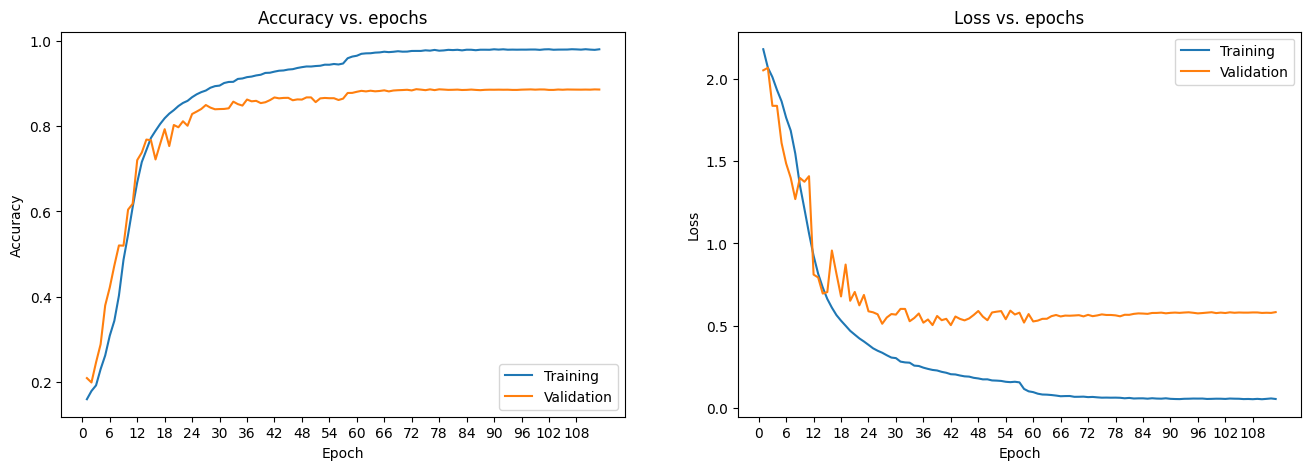

2022-08-09 07:07:25,479: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 07:07:50,576: INFO: test loss:0.5588
2022-08-09 07:07:50,577: INFO: test accuracy:0.8873
2022-08-09 07:07:50,579: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 07:07:50,581: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 07:07:50,581: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:07:50,582: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:07:50,583: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_50

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 07:07:51,484: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator


313/313 [==============================] - 1s 3ms/step


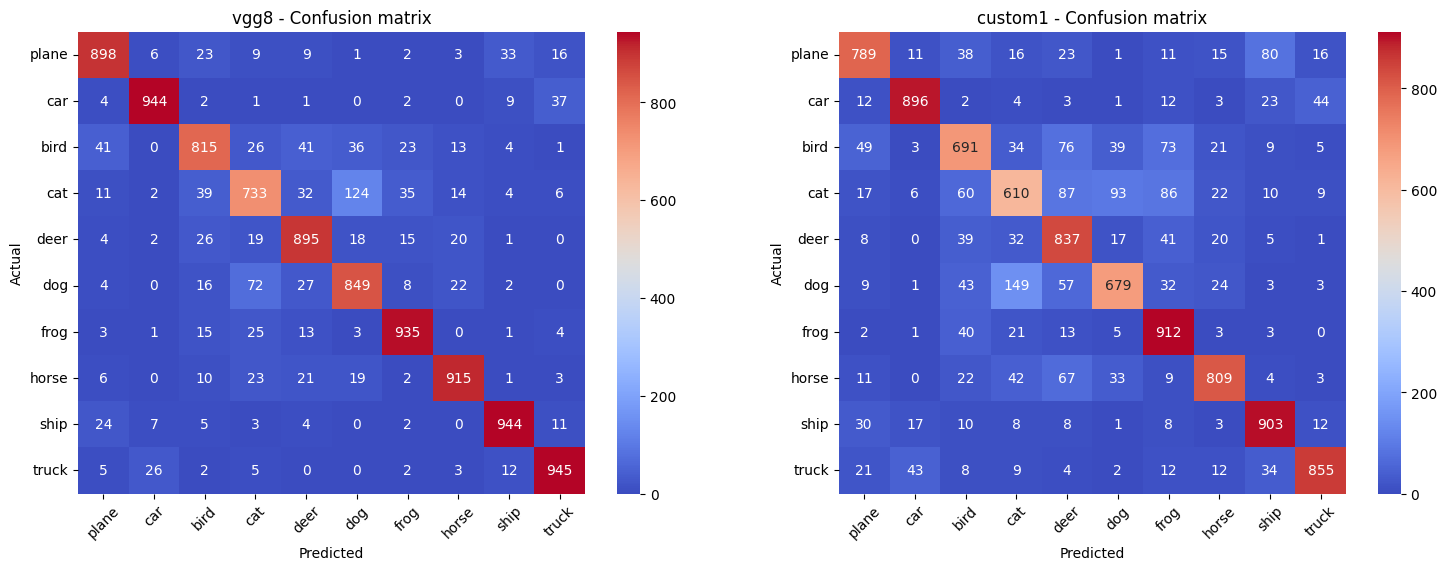

2022-08-09 07:07:56,339: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 07:07:57,806: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:07:57,808: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1
2022-08-09 07:07:58,624: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:07:58,628: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/mlp1
2022-08-09 07:07:58,915: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:07:58,917: INFO: loading model from /tf/eipi10/xuxiangwen.githu

1/1 [==============================] - 0s 13ms/step


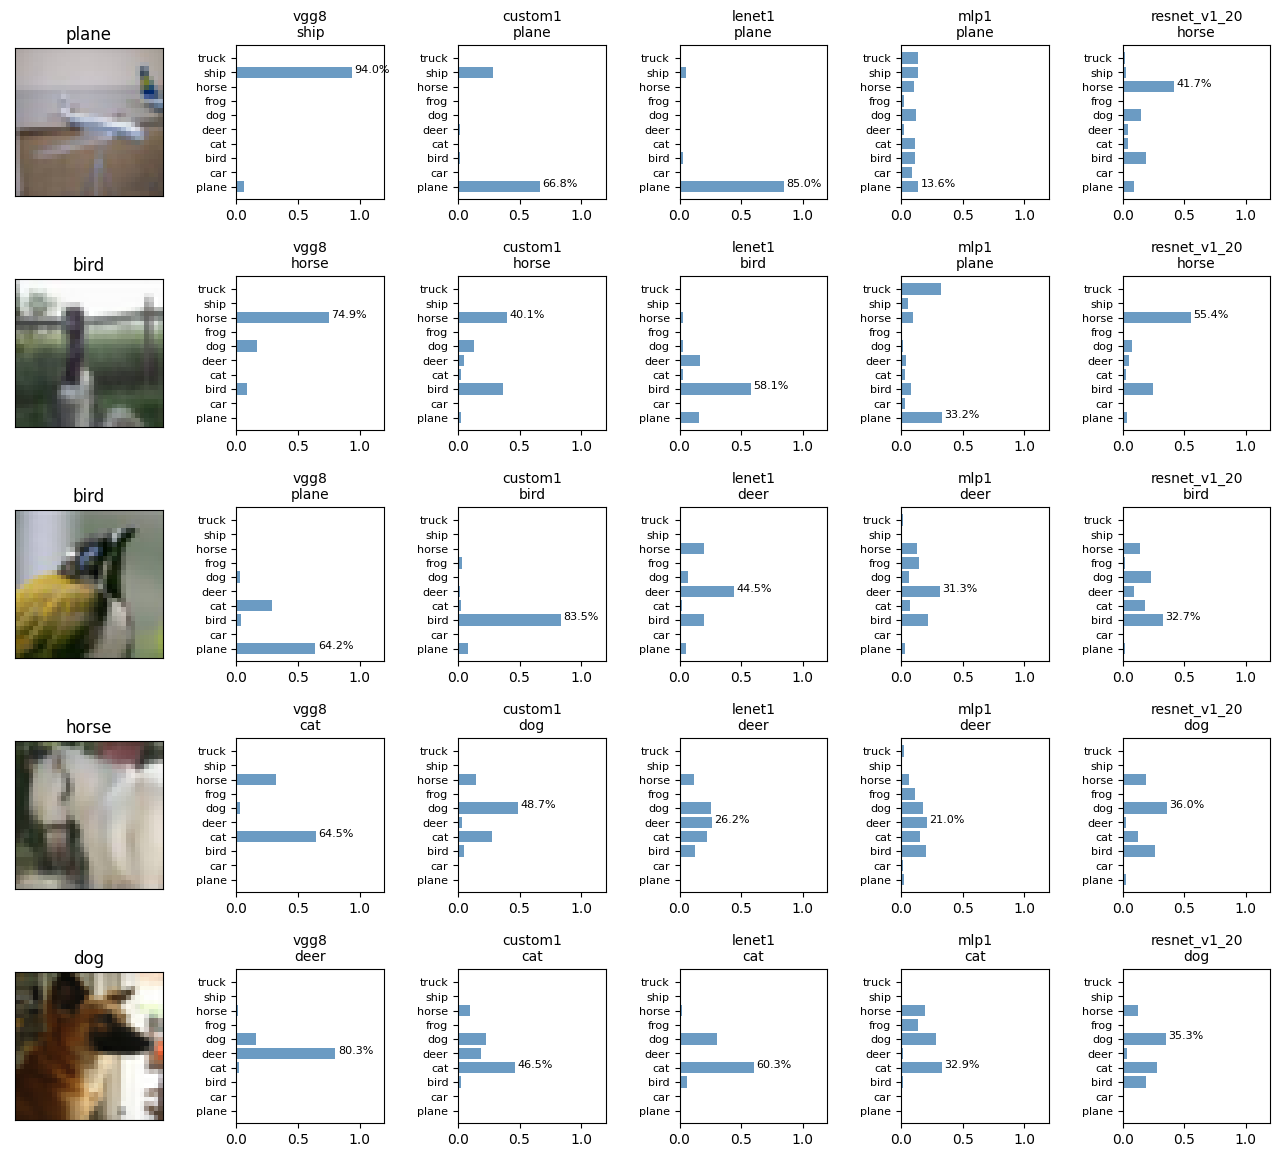

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
2       custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
3        lenet1  cifar10_0808_count_5000.ipynb          83170       891.5   
4          mlp1  cifar10_0808_count_5000.ipynb         394634       514.8   
5  resnet_v1_20  cifar10_0808_count_5000.ipynb         273066        19.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
2  2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
3  2022-08-09 06:19      0.5087     0.8214          0.8290         0.7138   
4  2022-08-09 06:03      1.4713     1.5869          0.4797         0.4324   
5  2022-08-09 05:40      2.5314     2.5575          0.2298         0.2252   

   train_auc  test_auc  
1     1.0000    0.9919  
2     0.9934    0.9776  
3     0.9847    0.9592  
4     0.8724    0.8477  
5     0.7653    0.7629

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 07:08:10,357: INFO: learning_rate=0.001
2022-08-09 07:08:10,358: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 07:08:10,365: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 07:08:10,483: INFO: model_params.resnet_v1_20.epochs=120
2022-08-09 07:08:10,483: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20, monitor=val_accuracy)
2022-08-09 07:08:10,484: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 07:08:10,485: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 07:08:10,485: INFO: use LearningRateScheduler()
2022-08-09 07:08:10,486: INFO: steps_per_epoch=1562
2022-08-09 07:08:10,487: INFO: start training
2022-08-09 07:08:10,487: INFO: use_class_weight=False


Epoch 1/120
1559/1562 [============================>.] - ETA: 0s - loss: 1.5241 - accuracy: 0.5097

2022-08-09 07:08:47,360: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:08:50,500: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 40s 24ms/step - loss: 1.5234 - accuracy: 0.5100 - val_loss: 1.3731 - val_accuracy: 0.5633 - lr: 0.0010
Epoch 2/120
1562/1562 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.6734

2022-08-09 07:09:23,746: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:09:27,189: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 1.0850 - accuracy: 0.6734 - val_loss: 1.3860 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 3/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.9019 - accuracy: 0.7432

2022-08-09 07:10:00,604: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:10:04,010: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 24ms/step - loss: 0.9016 - accuracy: 0.7433 - val_loss: 1.0955 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 4/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.7905 - accuracy: 0.7865 - val_loss: 1.3417 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 5/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.7098 - accuracy: 0.8185 - val_loss: 1.3295 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 6/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.8440

2022-08-09 07:11:30,454: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:11:33,869: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 36s 23ms/step - loss: 0.6480 - accuracy: 0.8441 - val_loss: 1.2350 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 7/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.6020 - accuracy: 0.8635 - val_loss: 1.5428 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.5609 - accuracy: 0.8820 - val_loss: 1.4305 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.5362 - accuracy: 0.8936 - val_loss: 1.6978 - val_accuracy: 0.6665 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.5124 - accuracy: 0.9051 - val_loss: 1.5980 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 11/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.5001 - accuracy: 0.9120

2022-08-09 07:13:53,416: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:13:56,827: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.5002 - accuracy: 0.9120 - val_loss: 1.4387 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.9167

2022-08-09 07:14:29,795: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:14:33,174: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 36s 23ms/step - loss: 0.4951 - accuracy: 0.9167 - val_loss: 1.3468 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 13/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.4792 - accuracy: 0.9269

2022-08-09 07:15:06,558: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:15:10,010: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 24ms/step - loss: 0.4792 - accuracy: 0.9270 - val_loss: 1.3703 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.4783 - accuracy: 0.9284 - val_loss: 1.3906 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.4738 - accuracy: 0.9311 - val_loss: 1.5274 - val_accuracy: 0.7231 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.4685 - accuracy: 0.9361 - val_loss: 1.6249 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.4649 - accuracy: 0.9390 - val_loss: 1.7449 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 18/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.9402
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [===================

2022-08-09 07:17:56,051: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:17:59,586: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.3788 - accuracy: 0.9722 - val_loss: 1.1440 - val_accuracy: 0.7959 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/120
1562/1562 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.9962

2022-08-09 07:18:32,663: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:18:36,132: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.3060 - accuracy: 0.9962 - val_loss: 1.1819 - val_accuracy: 0.8021 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.2747 - accuracy: 0.9981 - val_loss: 1.4548 - val_accuracy: 0.7829 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.2778 - accuracy: 0.9901 - val_loss: 1.4883 - val_accuracy: 0.7668 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.2591 - accuracy: 0.9931 - val_loss: 1.3569 - val_accuracy: 0.7890 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.2511 - accu

2022-08-09 07:24:54,182: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:24:57,755: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.1923 - accuracy: 0.9966 - val_loss: 1.3275 - val_accuracy: 0.8090 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/120
1562/1562 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9999

2022-08-09 07:25:30,883: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:25:34,327: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.1798 - accuracy: 0.9999 - val_loss: 1.3297 - val_accuracy: 0.8099 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 1.0000

2022-08-09 07:26:07,182: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:26:10,717: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 36s 23ms/step - loss: 0.1716 - accuracy: 1.0000 - val_loss: 1.3420 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.1572 - accuracy: 1.0000 - val_loss: 1.3493 - val_accuracy: 0.8121 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.1319 - accuracy: 1.0000 - val_loss: 1.3709 - val_accuracy: 0.8104 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.1214 - accuracy: 0.9953 - val_loss: 1.3933 - val_accuracy: 0.8048 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.1076 - accuracy: 0.9996

2022-08-09 07:28:56,564: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:29:00,102: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 24ms/step - loss: 0.0984 - accuracy: 1.0000 - val_loss: 1.3852 - val_accuracy: 0.8131 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0892 - accuracy: 1.0000 - val_loss: 1.3880 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.0940 - accuracy: 0.9936 - val_loss: 1.3764 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0813 - accuracy: 0.9974 - val_loss: 1.4152 - val_accuracy: 0.8032 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.0737 - accuracy: 0.9995

2022-08-09 07:37:33,587: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:37:36,614: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 24ms/step - loss: 0.3323 - accuracy: 0.9753 - val_loss: 1.0013 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 62/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.2809 - accuracy: 0.9947

2022-08-09 07:38:10,622: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:38:13,628: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 24ms/step - loss: 0.2808 - accuracy: 0.9947 - val_loss: 1.0420 - val_accuracy: 0.8251 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.2579 - accuracy: 0.9994 - val_loss: 1.0966 - val_accuracy: 0.8246 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9998
Epoch 64: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 26s 17ms/step - loss: 0.2391 - accuracy: 0.9998 - val_loss: 1.1464 - val_accuracy: 0.8248 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.2237 - accuracy: 1.0000 - val_loss: 1.1713 - val_accuracy: 0.8251 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/120
1559/1562 [============================>.] - 

2022-08-09 07:40:07,575: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


2022-08-09 07:40:10,561: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20/assets


1562/1562 [==============================] - 37s 24ms/step - loss: 0.2119 - accuracy: 1.0000 - val_loss: 1.1902 - val_accuracy: 0.8252 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.1951 - accuracy: 1.0000 - val_loss: 1.2082 - val_accuracy: 0.8249 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.1741 - accuracy: 1.0000 - val_loss: 1.2266 - val_accuracy: 0.8251 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.1503 - accuracy: 1.0000 - val_loss: 1.2466 - val_accuracy: 0.8243 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.1257 - accu

Epoch 00102: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 102/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 1.8025 - val_accuracy: 0.8096 - lr: 3.1623e-06
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 103/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 1.8128 - val_accuracy: 0.8097 - lr: 3.1623e-06
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.8244 - val_accuracy: 0.8091 - lr: 3.1623e-06
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 1.8355 - val_accuracy: 0.8087 - lr: 3.1623e-06
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
Epo

2022-08-09 07:57:54,492: INFO: finish training [elapsed time: 2984.01 seconds]


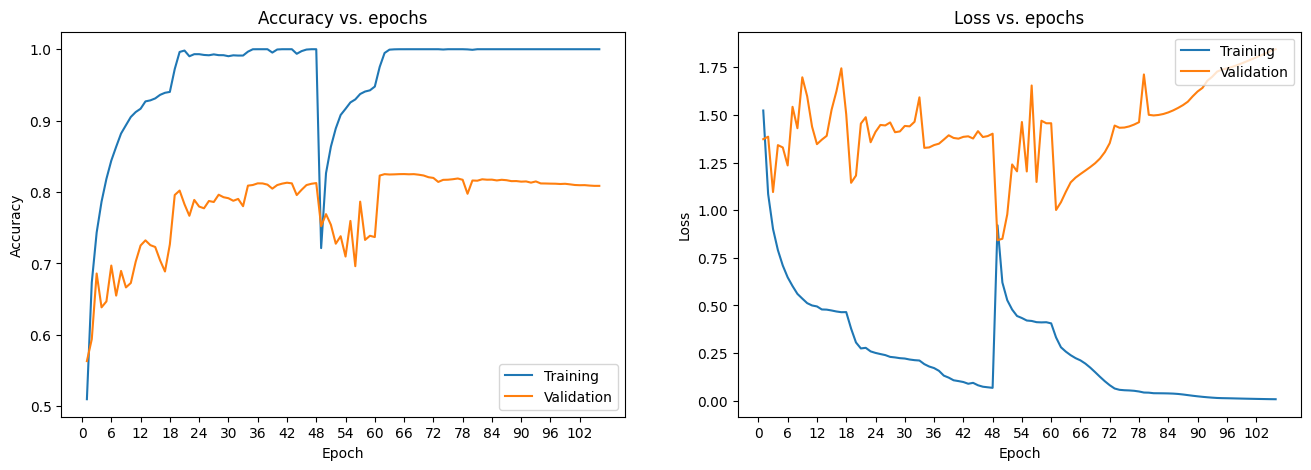

2022-08-09 07:57:54,904: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-09 07:58:32,599: INFO: test loss:1.1902
2022-08-09 07:58:32,600: INFO: test accuracy:0.8252
2022-08-09 07:58:32,604: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 07:58:32,605: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 07:58:32,606: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:58:32,607: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:58:32,608: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_50

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 07:58:34,186: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator


313/313 [==============================] - 1s 3ms/step


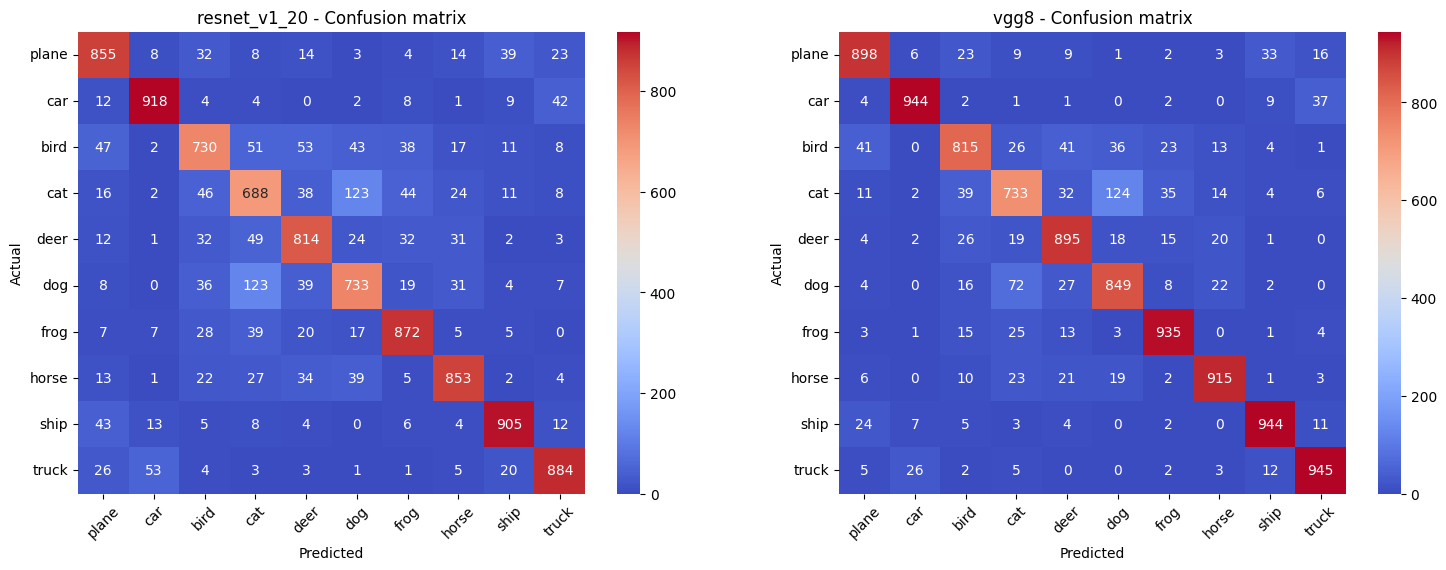

2022-08-09 07:58:40,226: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-09 07:58:41,741: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:58:41,747: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/custom1
2022-08-09 07:58:42,671: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:58:42,677: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/lenet1
2022-08-09 07:58:43,474: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:58:43,479: INFO: loading model from /tf/eipi10/xuxiangwen.gi

1/1 [==============================] - 0s 9ms/step


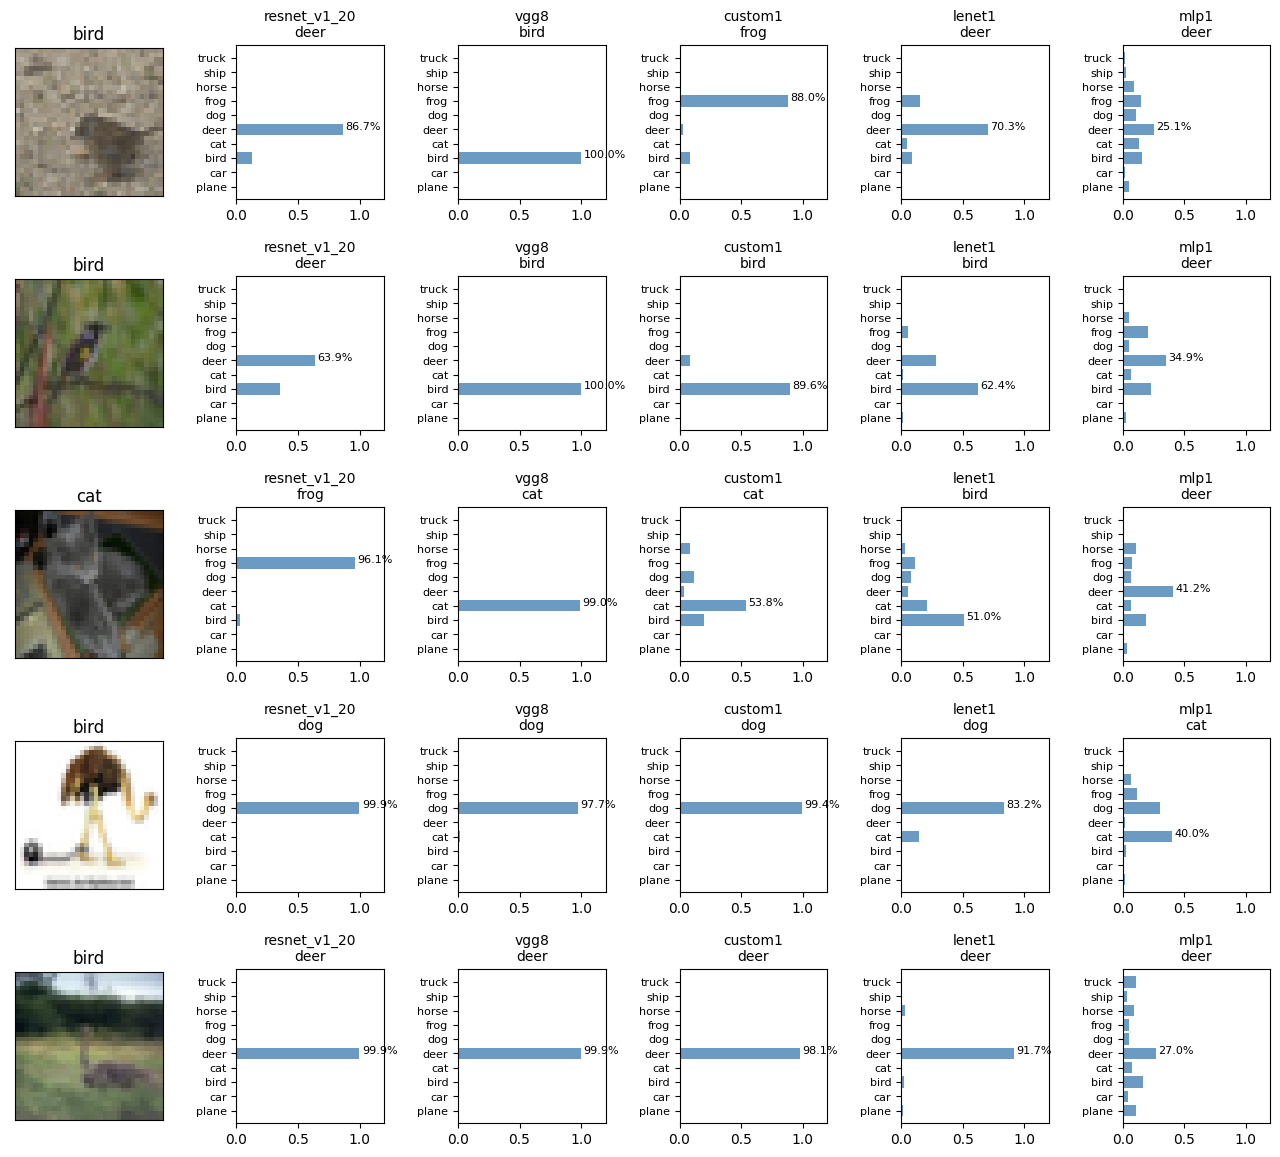

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
2  resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
3       custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
4        lenet1  cifar10_0808_count_5000.ipynb          83170       891.5   
5          mlp1  cifar10_0808_count_5000.ipynb         394634       514.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
2  2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
3  2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
4  2022-08-09 06:19      0.5087     0.8214          0.8290         0.7138   
5  2022-08-09 06:03      1.4713     1.5869          0.4797         0.4324   

   train_auc  test_auc  
1     1.0000    0.9919  
2     1.0000    0.9810  
3     0.9934    0.9776  
4     0.9847    0.9592  
5     0.8724    0.8477

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [25]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 07:58:51,731: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 07:58:51,733: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 07:58:51,734: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 07:58:51,736: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 07:58:51,737: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 07:58:51,738: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
2           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
3   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
4   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
5        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
6        custom1        cifar10_0721_p100.ipynb          73738      1190.8   
7         lenet1        cifar10_0721_p100.ipynb          83170      1082.5   
8         lenet1  cifar10_0808_count_5000.ipynb          83170       891.5   
9   resnet_v1_20  cifar10_0808_count_2000.ipynb         273066        26.0   
10          mlp1  cifar10_0808_count_5000.ipynb         394634       514.8   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
2   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
3   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
4   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
5   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
6   2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   
7   2021-12-02 07:52      0.4513     0.7808          0.8461         0.7326   
8   2022-08-09 06:19      0.5087     0.8214          0.8290         0.7138   
9   2022-08-09 05:50      1.7470     1.7895          0.4466         0.4379   
10  2022-08-09 06:03      1.4713     1.5869          0.4797         0.4324   

    train_auc  test_auc  
1      1.0000    0.9920  
2      1.0000    0.9919  
3      1.0000    0.9810  
4      1.0000    0.9791  
5      0.9934    0.9776  
6      0.9929    0.9776  
7      0.9878    0.9628  
8      0.9847    0.9592  
9      0.8925    0.8835  
10     0.8724    0.8477

In [26]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 07:58:51,812: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 07:58:53,525: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 07:58:53,535: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 07:58:55,564: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/default.generator
2022-08-09 07:58:55,570: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/resnet_v1_20
2022-08-09 07:58:59,792: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 11ms/step


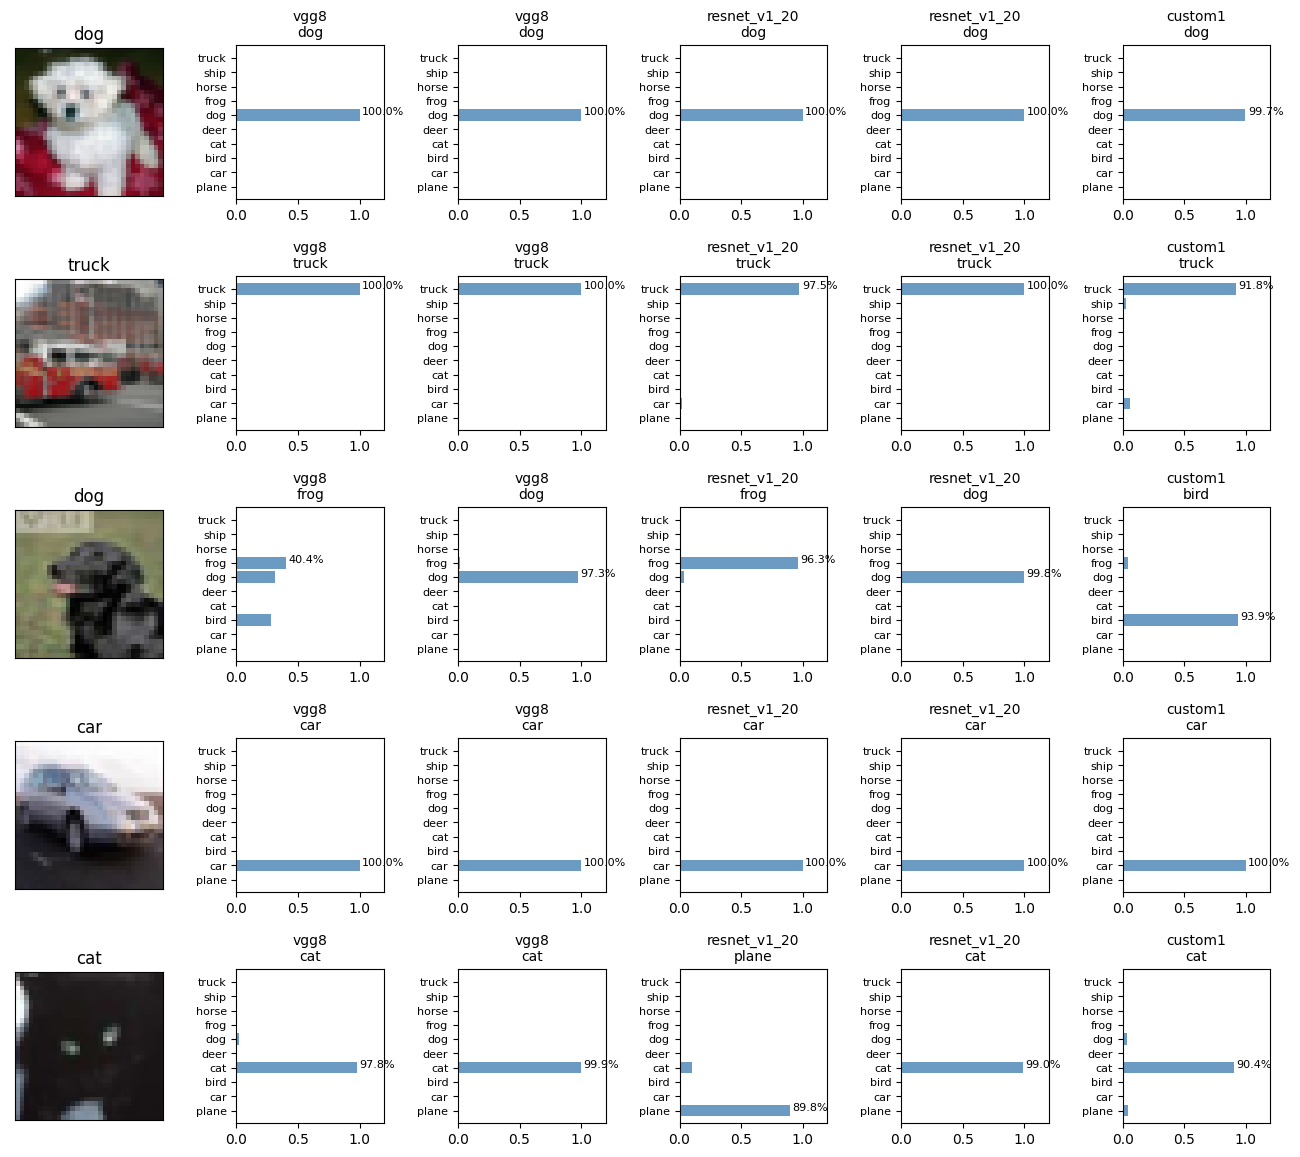

In [27]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 9ms/step


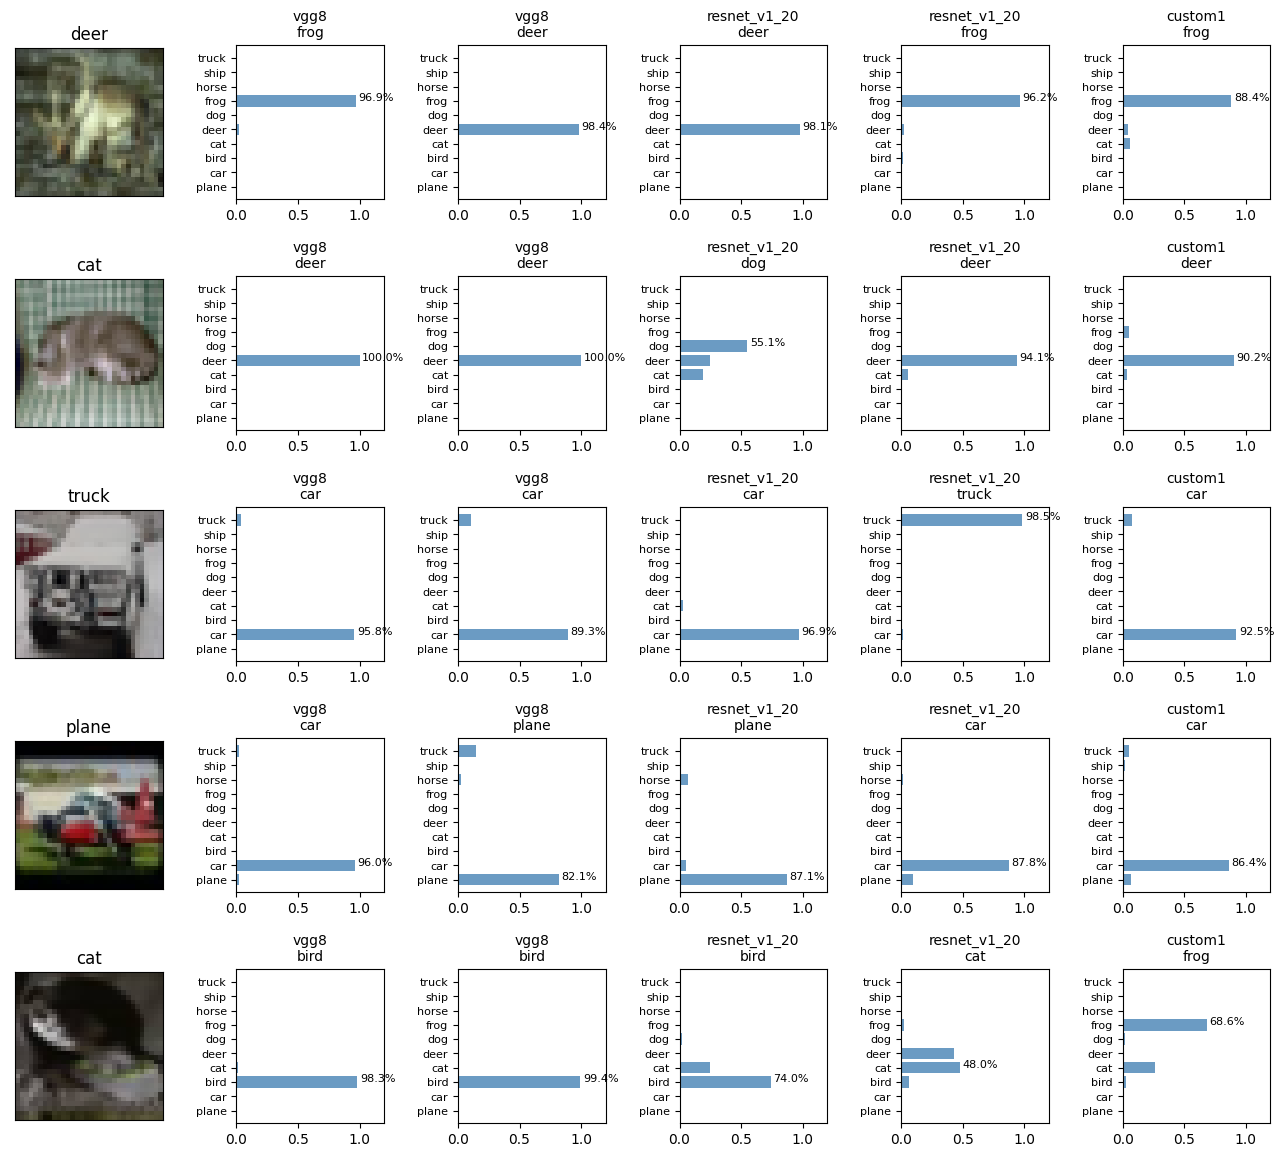

In [28]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [29]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5958887934684753, 'accuracy': 0.8920999765396118, 'mae': 23.795490264892578}
313/313 [==============================] - 1s 3ms/step
(10000, 10)


In [30]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 3ms/step


precision  recall        f1
plane   0.902874   0.911  0.906919
car     0.946269   0.951  0.948628
bird    0.870699   0.835  0.852476
cat     0.822599   0.728  0.772414
deer    0.878937   0.893  0.885913
dog     0.804878   0.858  0.830591
frog    0.892789   0.941  0.916261
horse   0.929071   0.930  0.929535
ship    0.940060   0.941  0.940530
truck   0.929283   0.933  0.931138

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9029    0.9110    0.9069      1000
         car     0.9463    0.9510    0.9486      1000
        bird     0.8707    0.8350    0.8525      1000
         cat     0.8226    0.7280    0.7724      1000
        deer     0.8789    0.8930    0.8859      1000
         dog     0.8049    0.8580    0.8306      1000
        frog     0.8928    0.9410    0.9163      1000
       horse     0.9291    0.9300    0.9295      1000
        ship     0.9401    0.9410    0.9405      1000
       truck     0.9293    0.9330    0.9311      1000

    accuracy                         0.8921     10000
   macro avg     0.8917    0.8921    0.8914     10000
weighted avg     0.8917    0.8921    0.8914     10000



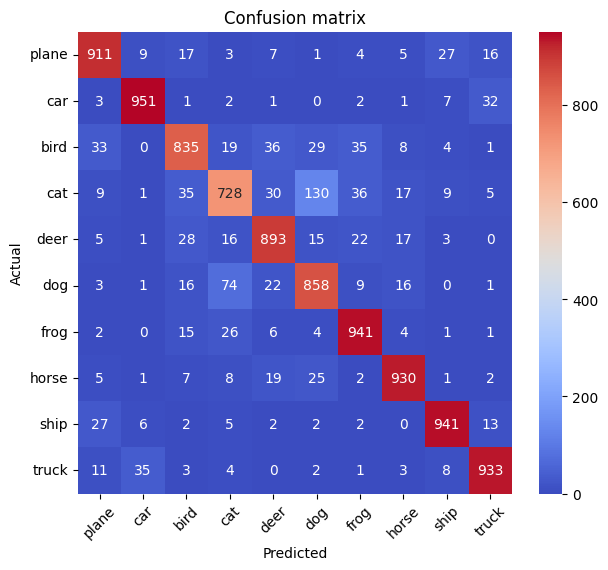

In [31]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [32]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset